<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/%D0%A1%D0%A1_ONE_SYMB_Copy_of_V11_of_EQ_no_prof_simpl_new_proffs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

image_width = 1000
image_height = 200

In [0]:
import os
import cv2
from xml.dom import minidom
import matplotlib.pyplot as plt
from math import floor
from random import random
import scipy as sp


class ArtificialHandwrittingObject:
    
    def __init__(self, name, img):
        self.name = name
        self.image = img

class ArtificialHandwritting:
    
    def __init__(self, datasetDir, scale, image_width, image_height, encode_word):
        self.scale = scale
        self.height = image_height
        self.width = image_width
        self.datasetDirectory = datasetDir
        self.data = {}
        self.initOffsets()
        self.encode_word = encode_word
        
        for f_name in os.listdir(datasetDir):
            if not f_name.endswith(".xml"):
                continue
            full_path = datasetDir + f_name
            print(full_path)
            self.process_xml(full_path)
            
    def initOffsets(self):
        self.offsets = {
            'a': 0,
            'b': -0.1,
            'c': 0,
            'd': 0,
            'e': 0,
            'f': -0.2,
            'g': +0.3,
            'h': 0,
            'i': -0.15,
            'j': +0.2,
            'k': 0,
            'l': -0.15,
            'm': 0,
            'n': 0,
            'o': 0,
            'p': 0,
            'q': +0.2,
            'r': 0,
            's': 0,
            't': -0.2,
            'u': 0,
            'v': 0,
            'w': 0,
            'x': 0,
            'y': +0.2,
            'z': 0,
        }
        
        
        
    def getValue(self, node, name):
        v  = node.getElementsByTagName(name) 
        if len(v) != 1:
            raise Exception()
        v = v[0].firstChild.data
        return v
    
    def make_random_batch(self, word_len, rand_x):
        alphabet = "abcdefghijklmnopqrstuvwxyz"
        texts = []
        datas = []
        #data = torch.FloatTensor(batch_size, self.image_height, self.image_width)
        for batch_idx in range(0, batch_size):
          w = ""
          for i in range(0, word_len):
            s_idx = floor(random()*len(alphabet))
            s = alphabet[s_idx]
            w += s
          x = floor(random()*rand_x) + 10
          d, _ = self.make_word(w, x)
          d = d = torch.as_tensor(d)#.unsqueeze(0)
          
          datas.append(d)
          w = self.encode_word(w)
          texts.append(w)
        t = torch.stack(texts)
        data = torch.stack(datas, dim=0)
        return data, t
          
       
    def make_word(self, word, x_start):
        center = self.height*0.5
        result = sp.ones([self.height, self.width], dtype="float32")
        candidates = []
        for k in self.data.keys():
            d = self.data[k]
            flag = True
            for s in word:
                if s not in d:
                    flag = False
                    break
            if flag:
                candidates.append(k)
        idx = floor(random()*len(candidates))
        if (len(candidates) == 0):
          print("Bad word: " + word)
          raise Exception()
        
        img_file = candidates[idx]
        page = self.data[img_file]
        x = x_start
        for s in word:
            s_idx = floor(len(page[s])*random())
            obj_im = page[s][s_idx].image
            c = 0.5*obj_im.shape[0]
            dy = 0 + floor(center - c + obj_im.shape[0]*(self.offsets[s]+random()*0.05))#+random()*0.05))
            #print(dy)
            #print(obj_im.dtype)
            result[dy: dy + obj_im.shape[0], x: x+obj_im.shape[1]] = obj_im
            x += obj_im.shape[1]
        return result, img_file  
      
            
    def process_xml(self, f_path):
        
        xml_file = minidom.parse(f_path)
        #xml_file.normalize()
        annotation = xml_file.getElementsByTagName('annotation')
        if len(annotation) != 1:
            raise Exception()
        annotation = annotation[0]
        img_name = self.getValue(annotation, 'filename')
        image_file = self.datasetDirectory + img_name
        img = cv2.imread(image_file, 0)
        print(image_file)
        objects = annotation.getElementsByTagName('object')
        #print(len(objects))
        content = {}
        for obj in objects:
            name  = self.getValue(obj, 'name')
            if name not in content:
                content[name] = []
            x_min = int(self.getValue(obj, 'xmin'))
            y_min = int(self.getValue(obj, 'ymin'))
            x_max = int(self.getValue(obj, 'xmax'))
            y_max = int(self.getValue(obj, 'ymax'))
            obj_im = img[y_min: y_max, x_min: x_max]
            s = self.scale
            sh = obj_im.shape
            obj_im = cv2.resize(obj_im, (floor(sh[1]*s), floor(sh[0]*s)), cv2.INTER_LANCZOS4)
            if obj_im.shape[0] > self.height:
                continue
            obj_im = sp.float32(obj_im)    
            obj_im = (obj_im - obj_im.min())/(obj_im.max() - obj_im.min())
            handwr_obj = ArtificialHandwrittingObject(name, obj_im)
            content[name].append(handwr_obj)
        if img_name in self.data:
            raise Exception()
        self.data[img_name] = content
        

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords

pad_length=-1
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1, pad_length=pad_length, rand_x=400)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
artificial_data = ArtificialHandwritting("./MyLetters/", 1.0, image_width, image_height, train_set.encode_word)
data, target = artificial_data.make_random_batch(3, 400)

./MyLetters/a01-107u.xml
./MyLetters/a01-107u.png
./MyLetters/a01-026u.xml
./MyLetters/a01-026u.png
./MyLetters/my.xml
./MyLetters/my.jpg
./MyLetters/a01-053u.xml
./MyLetters/a01-053u.png
./MyLetters/a01-128.xml
./MyLetters/a01-128.png
./MyLetters/a01-107.xml
./MyLetters/a01-107.png


In [0]:
artificial_data.data["my.jpg"].keys()

dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 't', 'v', 'w', 'x', 'y', 'z', 'j'])

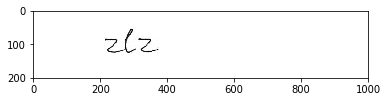

torch.Size([100, 200, 1000])

In [0]:
plt.imshow(data[0], cmap="gray")
plt.show()
data.shape

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
#!cat ./Handwritting/HTRDecoder.py


In [0]:
from Layers import *
#from HTREncoder import *
#from HTRDecoder import *
from HTRDiscriminator import *

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.unsqueeze(1).to(device)

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=True, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=1, bn=batchnorm, pool_layer=None))
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None),
#        ConvLayer([64, 64, (3, 1)], padding=0, stride=(3, 1), bn=batchnorm, pool_layer=None))
        
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)

        h = F.max_pool2d(h, [h.size(0), 1], padding=[0, 0])

        
        
        h = h.squeeze(2)

        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        
        return h

In [0]:
encoder = HTREncoder().to(device)

In [0]:
c = encoder(data)
c.shape

torch.Size([100, 64, 122])

In [0]:
class HTRDecoderResult:
  
  def __init__(self):
    None

class HTRDecoder(nn.Module):
    def __init__(self, batch_size, ntoken, encoded_width=122, encoded_height=64, batchnorm=False, dropout=True, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.batch_size = batch_size
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = features_size
        
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
            self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.3)

        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        #x = self.drop(x).squeeze()
        x = x.squeeze()
        #print("xxxxxxxxxxxx")
        #print(x.shape)
        if hidden is not None:
            hidden_m = hidden.permute(1, 0, 2)
            hidden_m = hidden_m.flatten(start_dim=1)
            #print(x.shape)
            #print(hidden_m.shape)
            x_m = x.flatten(start_dim=1)
            attention_inp = torch.cat([x_m, hidden_m], dim=1).detach()
            #print(attention_inp.shape)
            #print(x.shape)
            
            self.attention_weights = self.attention(attention_inp)
            self.attention_weights = F.softmax(self.attention_weights, dim=1).unsqueeze(1)
            #print("iiiif")
            #print(self.attention_weights.shape)
            
            self.attention_weights = self.attention_weights.repeat([1, self.encoded_height, 1])
            #print("fffff")
            #print(x.shape)
            #print(self.attention_weights.shape)
            x = x * self.attention_weights
        emb = self.embedding(prev).squeeze().detach()
        x = torch.cat([x.flatten(start_dim=1), emb], dim=1)
        x = x.unsqueeze(0)
        result = HTRDecoderResult()
        result.rnn_input = x
        result.input_hidden = hidden
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        #x = self.drop(x)
        x = self.decoder(x)
        x = F.log_softmax(x, dim=1)
        result.x = x
        result.hidden = hidden
        return result
      
    def makeHidden(self):
        if self.rnn_type == "LSTM":
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            h2 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return (h1, h2)
        else:
            h1 = torch.zeros(self.lstm_layers, self.batch_size, self.lstm_size)
            return h1


decoder = HTRDecoder(batch_size, len(train_set.codes), rnn_type="GRU").to(device)

In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
def test(max_size):
  print("Testing...")
  
  freq = 20
  
  test_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  test_loss = 0
  
  with torch.no_grad():  
    while True:
      if batch_idx > 100:
        break

      if True:
        l = 1 + floor((max_size - 1)*random())
        data, target = artificial_data.make_random_batch(l, 5)
        orig_data = data;
        data = data.unsqueeze(1).to(device)
        target = target.to(device)  
      else:  
        batch = test_set.make_batch()
        if batch is None:
          break
        orig_data, target = batch
        data = orig_data/255.0
        #data = data.view(batch_size, 1, image_width, image_height).to(device)
        data = data.unsqueeze(1).to(device)
        target = target.to(device)
      hidden = decoder.makeHidden().to(device)    

      loss = 0
      enc = encoder(data)
      #print(enc.shape)
      s = enc
      #print(s.shape)
      #s = s.flatten(start_dim=1).view(1, batch_size, -1)

      old_symbol[:, 0] = START

      for i in range(0, target.shape[1]):

        decoder_result = decoder(s, old_symbol, hidden)
        dec = decoder_result.x
        hidden = decoder_result.hidden

        recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
        old_symbol[:, 0] = target[:, i]

        loss += criterion(dec, target[:, i])
      c_loss += loss.item()/(target.shape[1] + 0)
      test_loss += loss.item()/(target.shape[1] + 0)
      if (batch_idx % freq == 0) and (batch_idx != 0):
        if True:#not use_teacher_forcing:
          print(target.shape[0])
          for k in range(0, min(3, target.shape[0])):
              decoded = recognition_result[k,0:target.shape[1] + 1]
              plt.imshow(orig_data[k].cpu(), cmap="gray")
              plt.show()
              print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
        c_loss /= freq 
        print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
        c_loss = 0
      batch_idx += 1  
  print("Test loss: %f" % (test_loss/batch_idx))   

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Layers import *

# Based on: https://github.com/aryopg/Professor_Forcing_Pytorch/blob/master/models/losses.py
class HTRDiscriminator(nn.Module):
    def __init__(self, batch_size, input_size, hidden_size, input_length, symbs_cnt):
        super(HTRDiscriminator, self).__init__()
        self.batch_size = batch_size
        self.embedding = nn.Embedding(symbs_cnt, 128)
        
        from math import floor
        self.hidden_cells = 256
        self.hidden_layers = 2
        
        self.hidden_size = hidden_size
        self.input_length = input_length
        self.rnn_layers = 2
        
        input_size = 8576
        gru_input_size = input_size#256*2
        
        #self.enc = FullyConnectedX([input_size, floor(input_size*0.7), gru_input_size], activation_fn=nn.ReLU())

        self.gru = nn.GRU(gru_input_size, hidden_size, self.rnn_layers)
        
        gru_out = hidden_size
        self.fc = FullyConnectedX([gru_out, floor(gru_out*0.7), floor(gru_out*0.3), 1], activation_fn=nn.ReLU())
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4, weight_decay=0.00005)
        
    def zero_grad(self):
        self.optimizer.zero_grad()

    def apply(self, hidden, hidden_states, dec_inputs, dec_outputs, targets):
        emb_outputs = self.embedding(dec_outputs)#.permute(1, 0, 2)
        hidden_states = hidden_states.permute(1, 0, 2).flatten(start_dim=1)
        dec_inputs = dec_inputs.squeeze(0)
#         print(emb_outputs.shape)
#         print(hidden_states.shape)
#         print(dec_inputs.shape)
        full_input = torch.cat([hidden_states, dec_inputs, emb_outputs], dim=1)
        #print(full_input.shape)
        output = full_input#self.enc(full_input)
        output = output.unsqueeze(0)
        output, hidden = self.gru(output, hidden)
        output= output.squeeze(0)
        out = self.fc(output)
#         print(out.shape)
#         print(targets.shape)
        loss = F.binary_cross_entropy_with_logits(out, targets)
        return loss, hidden

    def makeHidden(self):
        return torch.zeros(self.rnn_layers, self.batch_size, self.hidden_size)
      
discriminator = HTRDiscriminator(batch_size, 256*2, 512, 10, len(train_set.codes)).to(device)      

In [0]:
def apply_discriminator(s, target, use_teacher_forcing, train_mode, discriminator_target):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  train_mask = torch.ByteTensor(batch_size).to(device)
  train_mask[:] = 1

  hidden = decoder.makeHidden().to(device)    
  discriminator_loss = 0
  discriminator_hidden = discriminator.makeHidden().to(device)

  for i in range(0, target.shape[1] + 1):

    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    decoder_outputs = dec.topk(1, dim=1)[1].flatten()

    
    if train_mode:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden.detach(), decoder_result.input_hidden.detach(),decoder_result.rnn_input.detach(), decoder_outputs.detach(), discriminator_target)
    else:
      dl, discriminator_hidden = discriminator.apply(discriminator_hidden, decoder_result.input_hidden, decoder_result.rnn_input, decoder_outputs, discriminator_target)
      
    if i != 0:
      discriminator_loss += dl

    recognition_result[:, i] = decoder_outputs.detach()
    
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
    else:
      target_symbol = target[:, i]    
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target_symbol)
 
  discriminator_loss /= target.shape[1]
  return (recognition_result, loss, discriminator_loss)

In [0]:
def apply_decoder(s, target, use_teacher_forcing):
  loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  recognition_result.fill_(START)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  old_symbol[:, 0] = START

  hidden = decoder.makeHidden().to(device)  
  
  for i in range(0, target.shape[1] + 1):
    decoder_result = decoder(s, old_symbol, hidden)
    dec = decoder_result.x
    hidden = decoder_result.hidden

    recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
    
    if i == target.shape[1]:
      target_symbol = stop_symbol[:, 0]
    else:
      target_symbol = target[:, i]
    
    if use_teacher_forcing:
      old_symbol[:, 0] = target_symbol
    else:
      old_symbol[:, 0] = recognition_result[:, i]
    #import pdb; pdb.set_trace()

    loss += criterion(dec, target_symbol)
  return (recognition_result, loss)


batch_zeros = torch.zeros(batch_size, 1).to(device)
batch_ones = torch.ones(batch_size, 1).to(device)

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, weight_decay=0.00005)

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

teacher_forcing_ratio = 1#0.5

from random import random

def train(epoch, max_size, apply_professor):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 30
  
  train_set.to_start(max_size, equalize_freq=True)
  batch_idx = 0
  c_loss = 0

  
  train_loss = 0
  discr_applied = 0
  
  while True:
    if batch_idx > 400:
      break
    if True:
      l = 1 + floor((max_size - 1)*random())
      data, target = artificial_data.make_random_batch(l, 5)
      #data = data.unsqueeze(1).to(device)
      data = data.unsqueeze(1).to(device)
      #data = data.unsqueeze(1).to(device)
      target = target.to(device)
    else:
      batch = train_set.make_batch()
      if batch is None:
        break
      orig_data, target = batch
      data = orig_data/255.0
      #data = data.view(batch_size, 1, image_width, image_height).to(device)
      data = data.unsqueeze(1).to(device)
      target = target.to(device)


    encoder.zero_grad()
    decoder.zero_grad()

    
    enc = encoder(data)
    #print("xdddddddddddd")
    #print(data.shape)
    #print(enc.shape)
    s = enc
    #s = enc.permute(1, 0, 2)
    #s = s.squeeze(0)
    #print(s.shape)
    #print(s.shape)
    #s = s.flatten(start_dim=1).view(1, batch_size, -1)
    #s = s.flatten(start_dim=1).squeeze(0)
    #print("sssssssssssss")
    #print(s.shape)
    s = s.unsqueeze(0)
    
    discr_loss = 1
    if apply_professor:
      discriminator_optimizer.zero_grad()
      _, _, tf_loss = apply_discriminator(s, target, True, True, batch_ones)
      _, _, fr_loss = apply_discriminator(s, target, False, True, batch_zeros)
      dl = tf_loss + fr_loss
      discr_loss = dl.item()
      if (batch_idx % freq == 0) and (batch_idx != 0):
        print("Discr loss: %f" %(dl.item()))
      #print(dl)
      dl.backward()
      discriminator_optimizer.step()
   

      #     use_teacher_forcing = True if random() < teacher_forcing_ratio else False
      # #    recognition_result, loss, discriminator_loss = apply_discriminator(s, target, use_teacher_forcing, True, batch_zeros)
      #     recognition_result, loss = apply_decoder(s, target, use_teacher_forcing)
    batch_loss = None  
    if apply_professor and (discr_loss < 0.3):
      discriminator_optimizer.zero_grad()
      recognition_result, loss, discriminator_loss = apply_discriminator(s, target, True, False, batch_zeros)
      batch_loss = loss.item()
      loss = loss + discriminator_loss
      discr_applied += 1
      #print("Apply descr...")
    else:
      recognition_result, loss = apply_decoder(s, target, True)
      batch_loss = loss.item()

      
      
    c_loss += batch_loss/(target.shape[1] + 0)
    train_loss += batch_loss/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      
      if False:#True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1] + 1]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  '" + train_set.decode_word(target[k,:]) + "' -> '" + train_set.decode_word(decoded) + "'")
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    #grad_clip = 0.1
    #torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    #torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1
  print("Train loss: %f"%(train_loss/batch_idx))
  print("Discr applied %d times."%discr_applied)



In [0]:
file_name = "/gdrive/My Drive/v9.tar"

In [0]:
# state = torch.load(file_name)
# encoder.load_state_dict(state["encoder"])
# encoder_optimizer.load_state_dict(state["encoder_optimizer"])
# decoder.load_state_dict(state["decoder"])
# decoder_optimizer.load_state_dict(state["decoder_optimizer"])
# discriminator.load_state_dict(state["discriminator"])
# discriminator_optimizer.load_state_dict(state["discriminator_optimizer"])

Training epoch 0...
  Batch: 30 Loss: 7.9016220728556315
  Batch: 60 Loss: 4.8032022476196286
  Batch: 90 Loss: 4.118808269500732
  Batch: 120 Loss: 3.7713245391845702
  Batch: 150 Loss: 3.5501868724823
  Batch: 180 Loss: 3.4312218109766643
  Batch: 210 Loss: 3.36640625
  Batch: 240 Loss: 3.327837578455607
  Batch: 270 Loss: 3.3045435905456544
  Batch: 300 Loss: 3.2816367546717324
  Batch: 330 Loss: 3.250767223040263
  Batch: 360 Loss: 3.22106564839681
  Batch: 390 Loss: 3.177678696314494
Train loss: 3.857041
Discr applied 0 times.
Testing...
100


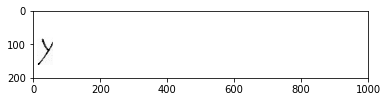

  'y' -> 'x<START>'


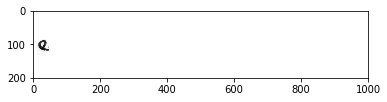

  'e' -> 'i<START>'


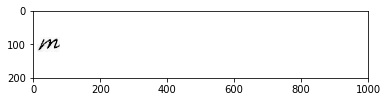

  'm' -> 'w<START>'
  Batch: 20 Loss: 3.2810834884643554
100


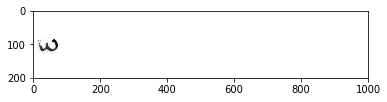

  'w' -> 'w<START>'


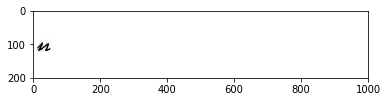

  'n' -> 'p<START>'


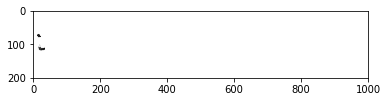

  'i' -> 's<START>'
  Batch: 40 Loss: 3.13368136882782
100


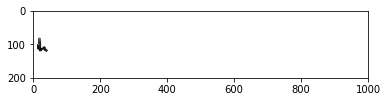

  'h' -> 'l<START>'


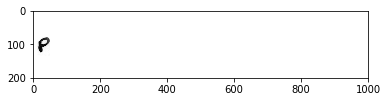

  'p' -> 'i<START>'


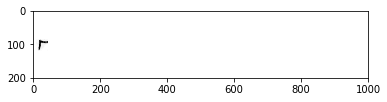

  'r' -> 'i<START>'
  Batch: 60 Loss: 3.1203505754470826
100


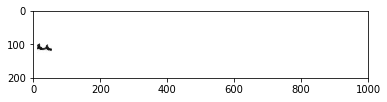

  'n' -> 'p<START>'


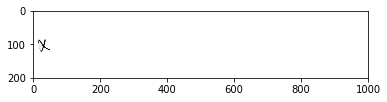

  'x' -> 'p<START>'


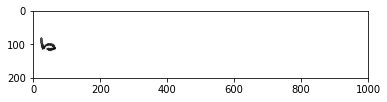

  'b' -> 'w<START>'
  Batch: 80 Loss: 3.120238697528839
100


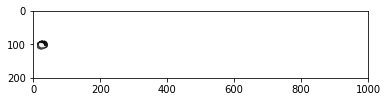

  'o' -> 'i<START>'


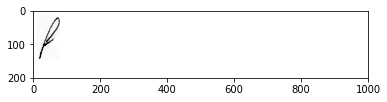

  'f' -> 'w<START>'


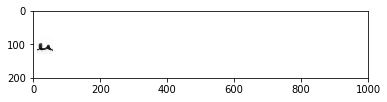

  'n' -> 'i<START>'
  Batch: 100 Loss: 3.1391720175743103
Test loss: 3.127629
Training epoch 1...
  Batch: 30 Loss: 3.225034817059835
  Batch: 60 Loss: 3.0606037934621173
  Batch: 90 Loss: 3.025726143519084
  Batch: 120 Loss: 3.00050794283549
  Batch: 150 Loss: 2.9554418325424194
  Batch: 180 Loss: 2.93369239171346
  Batch: 210 Loss: 2.9253050009409587
  Batch: 240 Loss: 2.879662609100342
  Batch: 270 Loss: 2.8542025009791057
  Batch: 300 Loss: 2.825375692049662
  Batch: 330 Loss: 2.7919880946477256
  Batch: 360 Loss: 2.766202712059021
  Batch: 390 Loss: 2.7508710861206054
Train loss: 2.910276
Discr applied 0 times.
Testing...
100


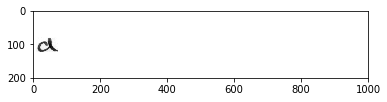

  'd' -> 'd<START>'


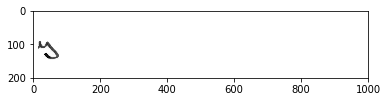

  'y' -> 'w<START>'


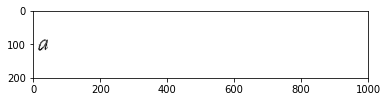

  'a' -> 't<START>'
  Batch: 20 Loss: 2.8571556210517883
100


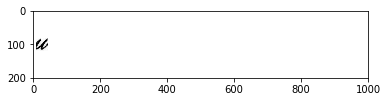

  'u' -> 'i<START>'


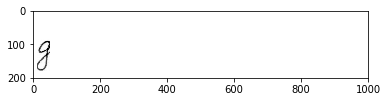

  'g' -> 'a<START>'


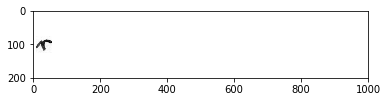

  'r' -> 'h<START>'
  Batch: 40 Loss: 2.737625277042389
100


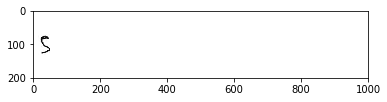

  's' -> 'c<START>'


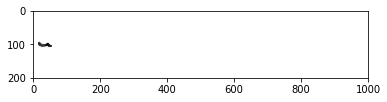

  'n' -> 'y<START>'


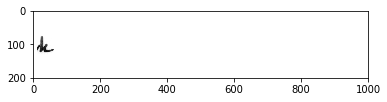

  'k' -> 'h<START>'
  Batch: 60 Loss: 2.7187191009521485
100


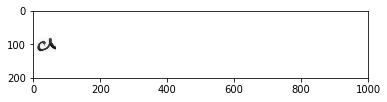

  'd' -> 'd<START>'


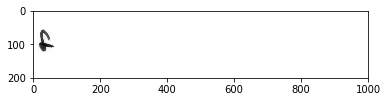

  'f' -> 'h<START>'


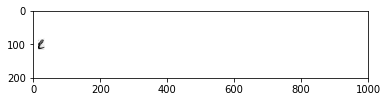

  'e' -> 'i<START>'
  Batch: 80 Loss: 2.7005558013916016
100


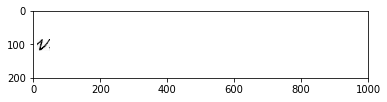

  'v' -> 'v<START>'


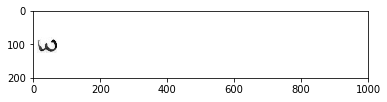

  'w' -> 'z<START>'


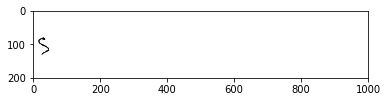

  's' -> 'i<START>'
  Batch: 100 Loss: 2.685345447063446
Test loss: 2.712753
Training epoch 2...
  Batch: 30 Loss: 2.777280068397522
  Batch: 60 Loss: 2.6794567346572875
  Batch: 90 Loss: 2.6205085357030233
  Batch: 120 Loss: 2.587893549601237
  Batch: 150 Loss: 2.537246656417847
  Batch: 180 Loss: 2.5283920923868815
  Batch: 210 Loss: 2.5016232252120973
  Batch: 240 Loss: 2.4257117033004763
  Batch: 270 Loss: 2.3720120747884113
  Batch: 300 Loss: 2.2997209866841635
  Batch: 330 Loss: 2.2280627806981403
  Batch: 360 Loss: 2.1862377007802327
  Batch: 390 Loss: 2.108146333694458
Train loss: 2.433481
Discr applied 0 times.
Testing...
100


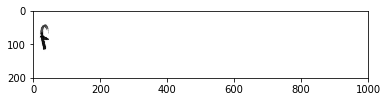

  'f' -> 't<START>'


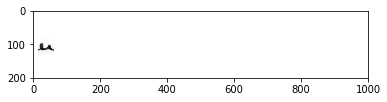

  'n' -> 'k<START>'


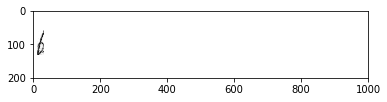

  'b' -> 't<START>'
  Batch: 20 Loss: 2.104866009950638
100


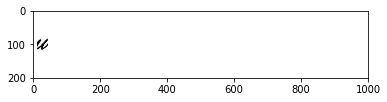

  'u' -> 'r<START>'


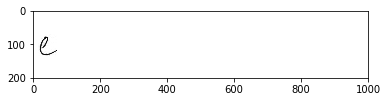

  'e' -> 'z<START>'


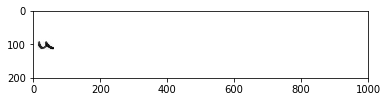

  'u' -> 'u<START>'
  Batch: 40 Loss: 2.00504532456398
100


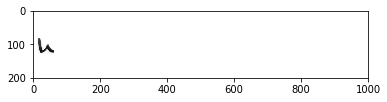

  'h' -> 'y<START>'


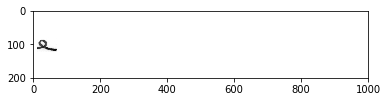

  'e' -> 'm<START>'


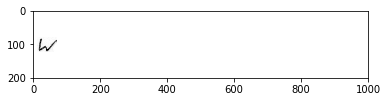

  'w' -> 'd<START>'
  Batch: 60 Loss: 2.0219568431377413
100


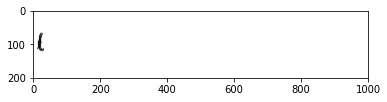

  'l' -> 'l<START>'


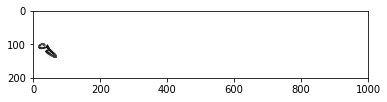

  'g' -> 'd<START>'


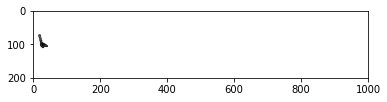

  't' -> 't<START>'
  Batch: 80 Loss: 2.0117411434650423
100


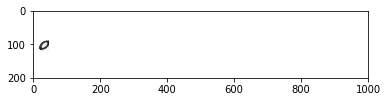

  'o' -> 'v<START>'


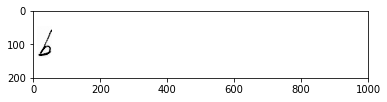

  'b' -> 'o<START>'


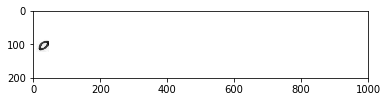

  'o' -> 'o<START>'
  Batch: 100 Loss: 1.9930729866027832
Test loss: 2.007264
Training epoch 3...
  Batch: 30 Loss: 2.036994723478953
  Batch: 60 Loss: 1.885313590367635
  Batch: 90 Loss: 1.7906441291173298
  Batch: 120 Loss: 1.6796701073646545
  Batch: 150 Loss: 1.6294318874677023
  Batch: 180 Loss: 1.5256134033203126
  Batch: 210 Loss: 1.4583049456278483
  Batch: 240 Loss: 1.3836187601089478
  Batch: 270 Loss: 1.30355992714564
  Batch: 300 Loss: 1.2207552115122478
  Batch: 330 Loss: 1.162206502755483
  Batch: 360 Loss: 1.1050841887791951
  Batch: 390 Loss: 1.0300262411435446
Train loss: 1.462327
Discr applied 0 times.
Testing...
100


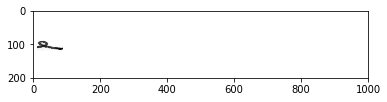

  'e' -> 'r<START>'


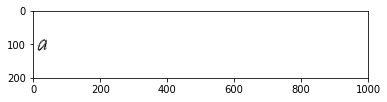

  'a' -> 'x<START>'


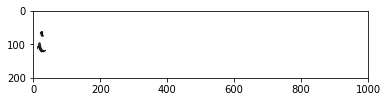

  'i' -> 'l<START>'
  Batch: 20 Loss: 1.033813264966011
100


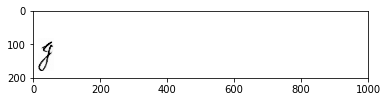

  'g' -> 'g<START>'


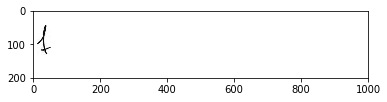

  'f' -> 'f<START>'


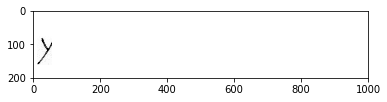

  'y' -> 'y<START>'
  Batch: 40 Loss: 0.9510844707489013
100


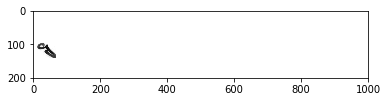

  'g' -> 'g<START>'


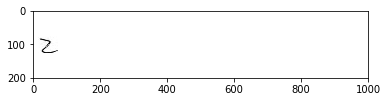

  'z' -> 'z<START>'


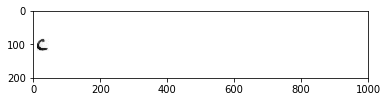

  'c' -> 'c<START>'
  Batch: 60 Loss: 0.9856840997934342
100


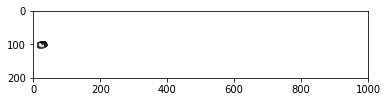

  'o' -> 's<START>'


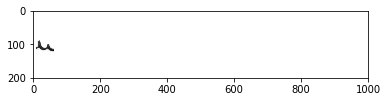

  'h' -> 'h<START>'


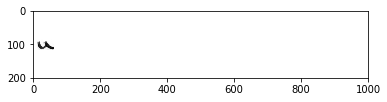

  'u' -> 'u<START>'
  Batch: 80 Loss: 0.9719707757234574
100


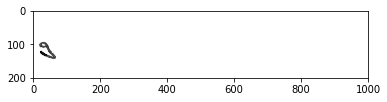

  'g' -> 'g<START>'


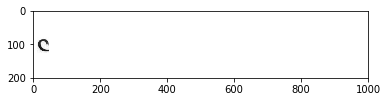

  'c' -> 'c<START>'


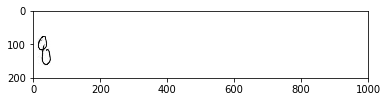

  'q' -> 'q<START>'
  Batch: 100 Loss: 0.9690469205379486
Test loss: 0.972594
Training epoch 4...
  Batch: 30 Loss: 1.004719090461731
  Batch: 60 Loss: 0.8962342003981273


KeyboardInterrupt: ignored

In [0]:


# for g in encoder_optimizer.param_groups:
#     g['lr'] = 3e-5

# for g in decoder_optimizer.param_groups:
#     g['lr'] = 3e-5    
    
for i in range(0, 100):
  max_size = 1
  train(i, max_size)
  test(max_size)

Training epoch 0...
  Batch: 30 Loss: 2.9565791726112365
  Batch: 60 Loss: 1.7476464251677195
  Batch: 90 Loss: 1.5843929171562194
  Batch: 120 Loss: 1.6034531503915788
  Batch: 150 Loss: 1.3563145955403646
  Batch: 180 Loss: 1.3694884369770686
  Batch: 210 Loss: 1.0835921297470728
  Batch: 240 Loss: 0.9324916650851568
  Batch: 270 Loss: 0.9454324771960576
  Batch: 300 Loss: 1.023019554714362
  Batch: 330 Loss: 1.2226234406232834
  Batch: 360 Loss: 0.9212132354577383
  Batch: 390 Loss: 0.8520894885063172
Train loss: 1.342154
Discr applied 0 times.
Testing...
100


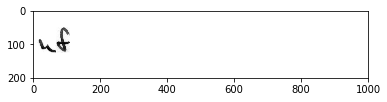

  'hf' -> 'hb<START>'


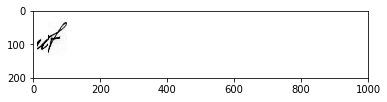

  'uf' -> 'db<START>'


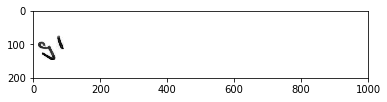

  'gl' -> 'gt<START>'
  Batch: 20 Loss: 1.0731481917202472
100


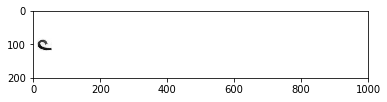

  'c' -> 'cw'


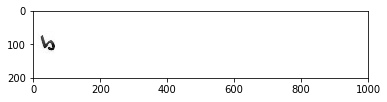

  'b' -> 'bn'


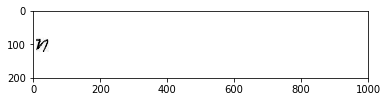

  'n' -> 'ne'
  Batch: 40 Loss: 1.0454410560429097
100


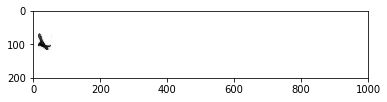

  't' -> 'tk'


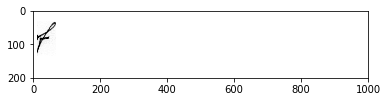

  'f' -> 'fg'


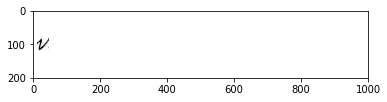

  'v' -> 'vy'
  Batch: 60 Loss: 1.050881212949753
100


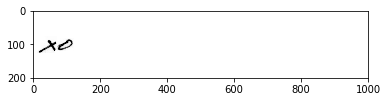

  'xo' -> 'xn<START>'


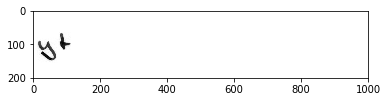

  'yt' -> 'yt<START>'


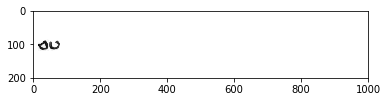

  'sv' -> 'a<STOP><START>'
  Batch: 80 Loss: 1.0544767178595067
100


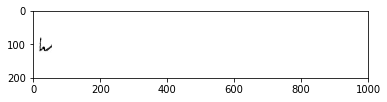

  'w' -> 'wb'


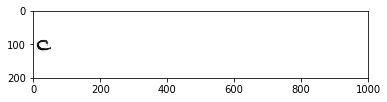

  'c' -> 'cf'


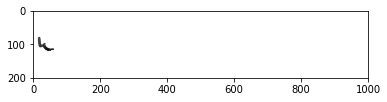

  'k' -> 'km'
  Batch: 100 Loss: 1.0740629196166993
Test loss: 1.049111
Training epoch 1...
  Batch: 30 Loss: 0.9563367232680321
  Batch: 60 Loss: 0.998606247206529
  Batch: 90 Loss: 0.9420081814130147
  Batch: 120 Loss: 0.8669033313790957
  Batch: 150 Loss: 0.7084133078654608
  Batch: 180 Loss: 0.9213642458120982
  Batch: 210 Loss: 0.69697987784942
  Batch: 240 Loss: 0.8615906198819479
  Batch: 270 Loss: 0.9167684962352117
  Batch: 300 Loss: 0.7491840422153473
  Batch: 330 Loss: 0.7132539128263792
  Batch: 360 Loss: 0.828461595873038
  Batch: 390 Loss: 0.676160895327727
Train loss: 0.833020
Discr applied 0 times.
Testing...
100


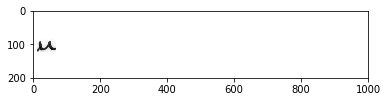

  'u' -> 'uc'


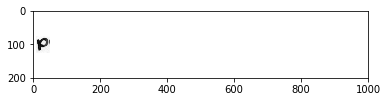

  'p' -> 'pu'


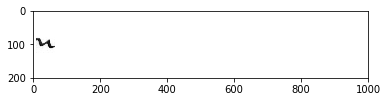

  'u' -> 'up'
  Batch: 20 Loss: 0.629908063262701
100


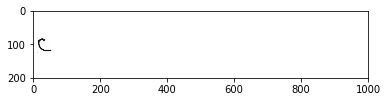

  'c' -> 'cs'


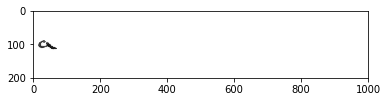

  'a' -> 'ax'


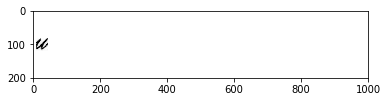

  'u' -> 'ut'
  Batch: 40 Loss: 0.5868350736796856
100


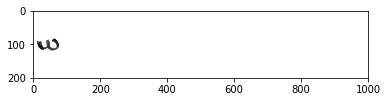

  'w' -> 'wc'


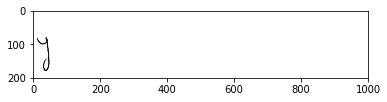

  'y' -> 'yl'


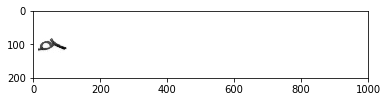

  'd' -> 'gz'
  Batch: 60 Loss: 0.5804577767848969
100


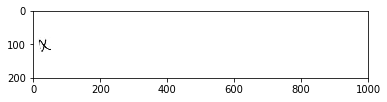

  'x' -> 'xf'


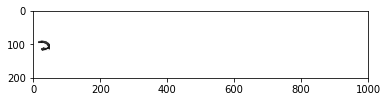

  's' -> 'sd'


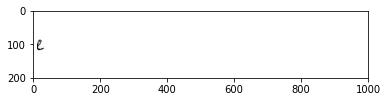

  'e' -> 'cg'
  Batch: 80 Loss: 0.3981346696615219
100


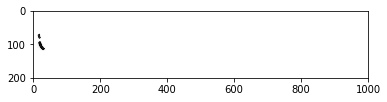

  'i' -> 'ig'


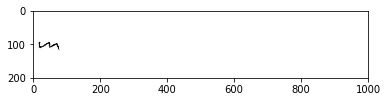

  'm' -> 'mt'


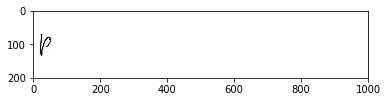

  'p' -> 'ps'
  Batch: 100 Loss: 0.6009093362838029
Test loss: 0.553712
Training epoch 2...
  Batch: 30 Loss: 0.8806860874096553
  Batch: 60 Loss: 0.7472314829627673
  Batch: 90 Loss: 0.5210293769836426
  Batch: 120 Loss: 0.7134599844614665
  Batch: 150 Loss: 0.773027274509271
  Batch: 180 Loss: 0.6415493786334991
  Batch: 210 Loss: 0.5253930183748404
  Batch: 240 Loss: 0.5230440547068914
  Batch: 270 Loss: 0.6743926371137301
  Batch: 300 Loss: 0.6249083615839481
  Batch: 330 Loss: 0.6987743037442367
  Batch: 360 Loss: 0.5790156605343024
  Batch: 390 Loss: 0.560373650242885
Train loss: 0.642566
Discr applied 0 times.
Testing...
100


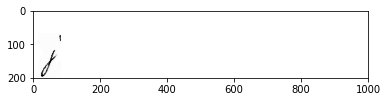

  'j' -> 'jf'


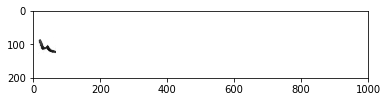

  'h' -> 'hm'


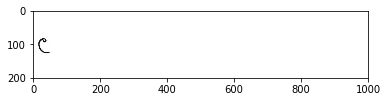

  'c' -> 'ck'
  Batch: 20 Loss: 0.45148725286126135
100


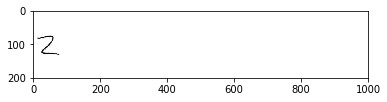

  'z' -> 'zx'


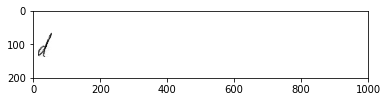

  'd' -> 'dp'


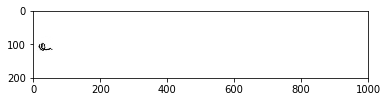

  'a' -> 'am'
  Batch: 40 Loss: 0.45162822417914866
100


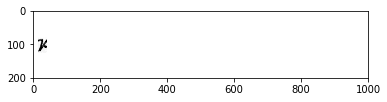

  'v' -> 'va'


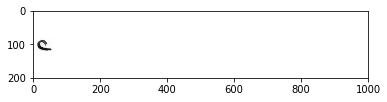

  'c' -> 'ch'


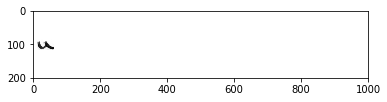

  'u' -> 'ud'
  Batch: 60 Loss: 0.6566232983022928
100


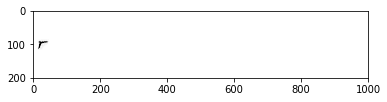

  'r' -> 'rq'


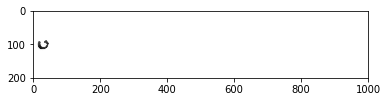

  'v' -> 'vt'


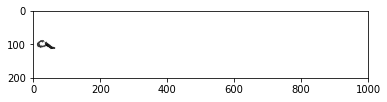

  'a' -> 'af'
  Batch: 80 Loss: 0.6643288008868694
100


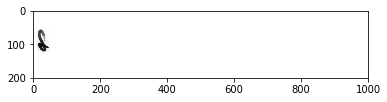

  'f' -> 'fs'


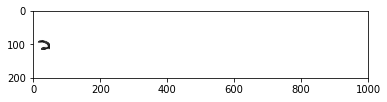

  's' -> 'sz'


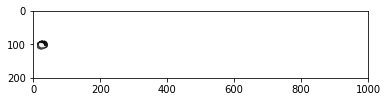

  'o' -> 'ow'
  Batch: 100 Loss: 0.4913896333426237
Test loss: 0.537714
Training epoch 3...
  Batch: 30 Loss: 0.8060614792009194
  Batch: 60 Loss: 0.45291885584592817
  Batch: 90 Loss: 0.5539354269703229
  Batch: 120 Loss: 0.5127168665329616
  Batch: 150 Loss: 0.5441256473461787
  Batch: 180 Loss: 0.5477494567632675
  Batch: 210 Loss: 0.6370317123830318
  Batch: 240 Loss: 0.4233812019228935
  Batch: 270 Loss: 0.3823741599917412
  Batch: 300 Loss: 0.4118707999587059
  Batch: 330 Loss: 0.5005214974284172
  Batch: 360 Loss: 0.6206317571302254
  Batch: 390 Loss: 0.3633266461392244
Train loss: 0.520617
Discr applied 0 times.
Testing...
100


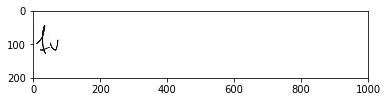

  'fv' -> 'fv<START>'


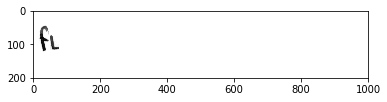

  'fl' -> 'fl<START>'


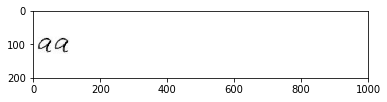

  'aa' -> 'ao<START>'
  Batch: 20 Loss: 0.5535288039594889
100


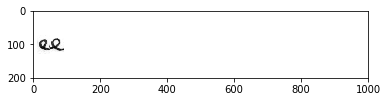

  'ee' -> 'ee<START>'


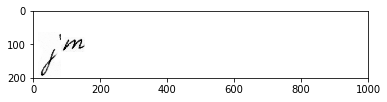

  'jm' -> 'jd<START>'


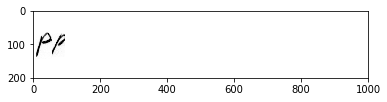

  'pp' -> 'pf<START>'
  Batch: 40 Loss: 0.3114745646715164
100


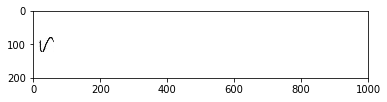

  'r' -> 'rh'


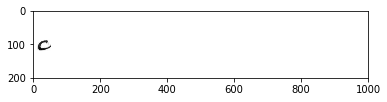

  'c' -> 'ci'


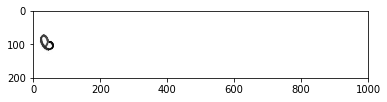

  'b' -> 'ba'
  Batch: 60 Loss: 0.46005947329103947
100


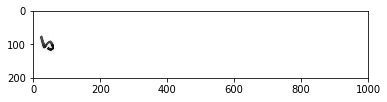

  'b' -> 'bf'


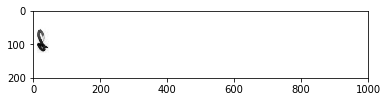

  'f' -> 'fz'


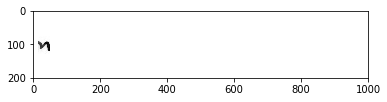

  'n' -> 'nw'
  Batch: 80 Loss: 0.24490494132041932
100


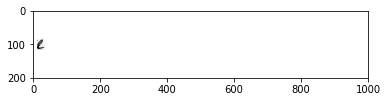

  'e' -> 'es'


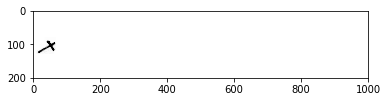

  'x' -> 'xq'


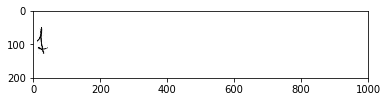

  'f' -> 'fz'
  Batch: 100 Loss: 0.45115404538810255
Test loss: 0.400222
Training epoch 4...
  Batch: 30 Loss: 0.4485444272557894
  Batch: 60 Loss: 0.45213386565446856
  Batch: 90 Loss: 0.4663076429317395
  Batch: 120 Loss: 0.5523786736031373
  Batch: 150 Loss: 0.39706591417392095
  Batch: 180 Loss: 0.4331632768114408
  Batch: 210 Loss: 0.32697778741518657
  Batch: 240 Loss: 0.389875715225935
  Batch: 270 Loss: 0.41098959743976593
  Batch: 300 Loss: 0.45789757172266643
  Batch: 330 Loss: 0.33442493379116056
  Batch: 360 Loss: 0.2898932645718257
  Batch: 390 Loss: 0.3304132151106993
Train loss: 0.402174
Discr applied 0 times.
Testing...
100


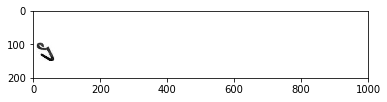

  'g' -> 'gp'


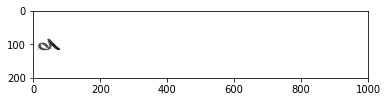

  'd' -> 'di'


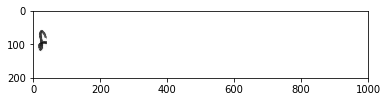

  'f' -> 'fm'
  Batch: 20 Loss: 0.24648953694850206
100


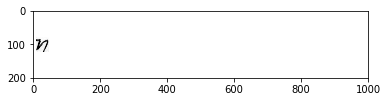

  'n' -> 'ni'


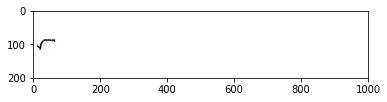

  'r' -> 'rs'


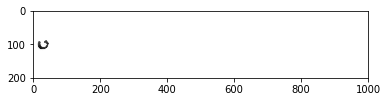

  'v' -> 'vg'
  Batch: 40 Loss: 0.4236435558646917
100


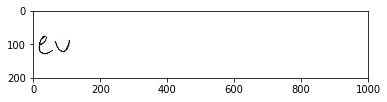

  'ev' -> 'ej<START>'


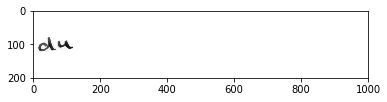

  'du' -> 'dn<START>'


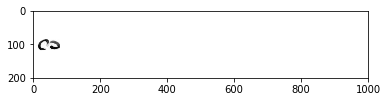

  'cs' -> 'cv<START>'
  Batch: 60 Loss: 0.41096791345626116
100


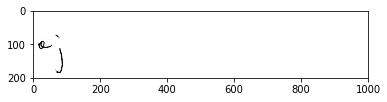

  'aj' -> 'aj<START>'


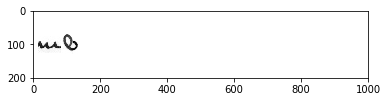

  'mb' -> 'mg<START>'


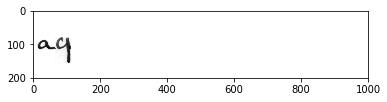

  'aq' -> 'aq<START>'
  Batch: 80 Loss: 0.38598225079476833
100


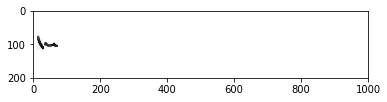

  'ln' -> 'li<START>'


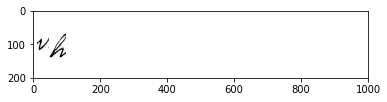

  'vh' -> 'vh<START>'


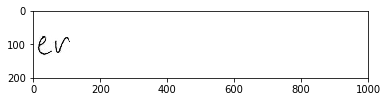

  'er' -> 'ew<START>'
  Batch: 100 Loss: 0.4334791688248515
Test loss: 0.376349
Training epoch 5...
  Batch: 30 Loss: 0.4006833684941133
  Batch: 60 Loss: 0.35245002172887324
  Batch: 90 Loss: 0.3639363322407007
  Batch: 120 Loss: 0.28965579631427923
  Batch: 150 Loss: 0.33717170159022014
  Batch: 180 Loss: 0.3982019296536843
  Batch: 210 Loss: 0.2959110338240862
  Batch: 240 Loss: 0.359238755206267
  Batch: 270 Loss: 0.3337903317064047
  Batch: 300 Loss: 0.35857173018157484
  Batch: 330 Loss: 0.46291936909159026
  Batch: 360 Loss: 0.3532920926809311
  Batch: 390 Loss: 0.2237527468552192
Train loss: 0.347509
Discr applied 0 times.
Testing...
100


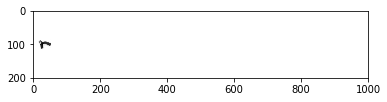

  'r' -> 'rz'


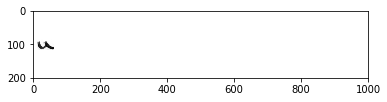

  'u' -> 'uc'


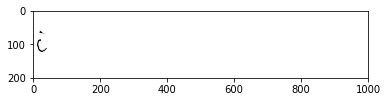

  'i' -> 'ir'
  Batch: 20 Loss: 0.37140459604561327
100


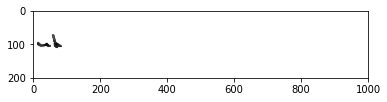

  'nt' -> 'nt<START>'


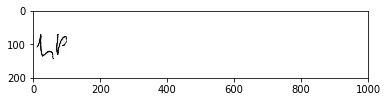

  'hp' -> 'hp<START>'


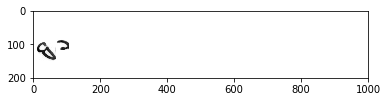

  'gs' -> 'gs<START>'
  Batch: 40 Loss: 0.1968703640624881
100


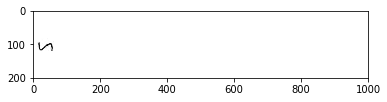

  'n' -> 'nr'


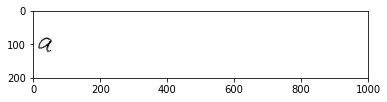

  'a' -> 'as'


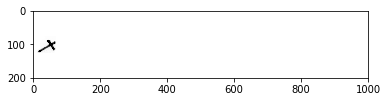

  'x' -> 'xt'
  Batch: 60 Loss: 0.31259455215185883
100


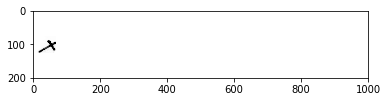

  'x' -> 'xj'


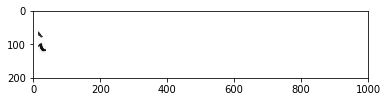

  'i' -> 'iz'


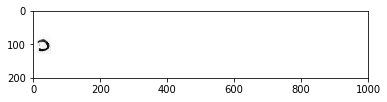

  's' -> 'sh'
  Batch: 80 Loss: 0.18918365351855754
100


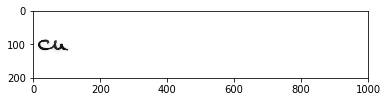

  'ck' -> 'ck<START>'


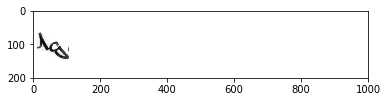

  'lg' -> 'lg<START>'


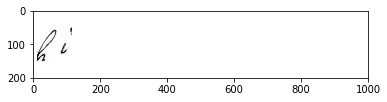

  'hi' -> 'hr<START>'
  Batch: 100 Loss: 0.2676655385643244
Test loss: 0.264895
Training epoch 6...
  Batch: 30 Loss: 0.32825254735847315
  Batch: 60 Loss: 0.36327479742467406
  Batch: 90 Loss: 0.3330842969318231
  Batch: 120 Loss: 0.23027643822133542
  Batch: 150 Loss: 0.2732197571545839
  Batch: 180 Loss: 0.2779347797234853
  Batch: 210 Loss: 0.3495350545893113
  Batch: 240 Loss: 0.25258618257939813
  Batch: 270 Loss: 0.3077170958121618
  Batch: 300 Loss: 0.22097286159793536
  Batch: 330 Loss: 0.28291450378795463
  Batch: 360 Loss: 0.2931508133808772
  Batch: 390 Loss: 0.27229357572893303
Train loss: 0.292653
Discr applied 0 times.
Testing...
100


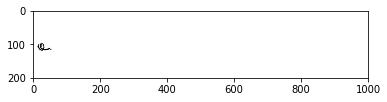

  'a' -> 'aa'


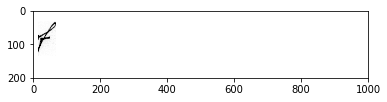

  'f' -> 'fw'


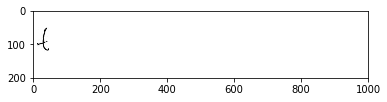

  't' -> 'tm'
  Batch: 20 Loss: 0.3138607878237963
100


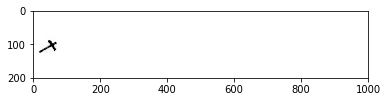

  'x' -> 'xj'


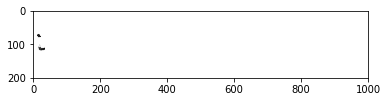

  'i' -> 'io'


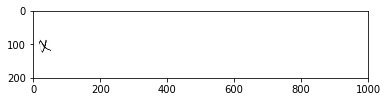

  'x' -> 'xt'
  Batch: 40 Loss: 0.2704278013668954
100


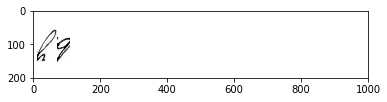

  'hq' -> 'hg<START>'


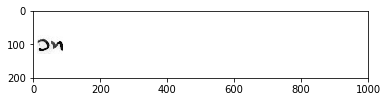

  'sn' -> 'sh<START>'


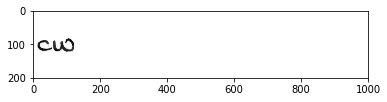

  'cw' -> 'cw<START>'
  Batch: 60 Loss: 0.2903068969026208
100


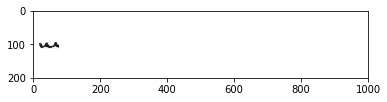

  'm' -> 'me'


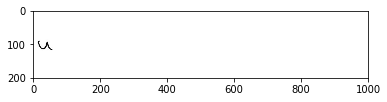

  'u' -> 'uy'


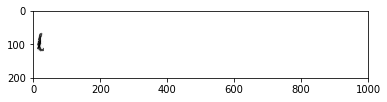

  'l' -> 'lv'
  Batch: 80 Loss: 0.29029398402199147
100


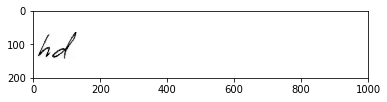

  'hd' -> 'hd<START>'


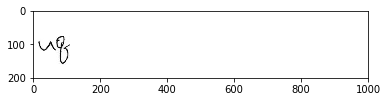

  'uq' -> 'ug<START>'


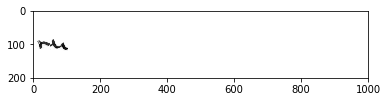

  'rh' -> 'rh<START>'
  Batch: 100 Loss: 0.3478184940293431
Test loss: 0.299546
Training epoch 7...
  Batch: 30 Loss: 0.2947649974375963
  Batch: 60 Loss: 0.24832398022214572
  Batch: 90 Loss: 0.24745652253429096
  Batch: 120 Loss: 0.3020352532466253
  Batch: 150 Loss: 0.2370921812330683
  Batch: 180 Loss: 0.24508015705893438
  Batch: 210 Loss: 0.25671068467199804
  Batch: 240 Loss: 0.217139146104455
  Batch: 270 Loss: 0.22287713599701722
  Batch: 300 Loss: 0.28889730529238783
  Batch: 330 Loss: 0.19570159794141848
  Batch: 360 Loss: 0.20699629839509726
  Batch: 390 Loss: 0.29725087409218154
Train loss: 0.251409
Discr applied 0 times.
Testing...
100


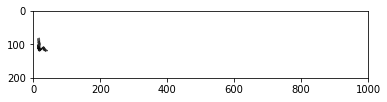

  'h' -> 'hi'


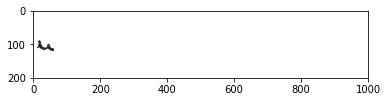

  'h' -> 'hb'


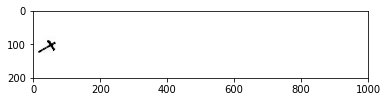

  'x' -> 'xy'
  Batch: 20 Loss: 0.20291546676307917
100


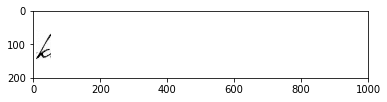

  'k' -> 'kg'


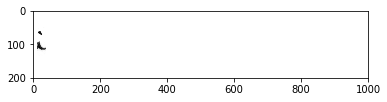

  'i' -> 'ie'


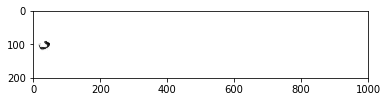

  'v' -> 'vc'
  Batch: 40 Loss: 0.23101731995120645
100


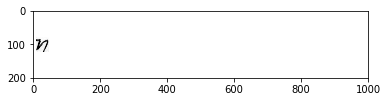

  'n' -> 'nm'


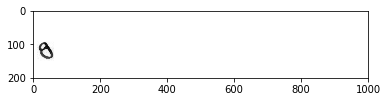

  'g' -> 'ge'


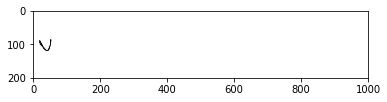

  'v' -> 'vl'
  Batch: 60 Loss: 0.2121128674596548
100


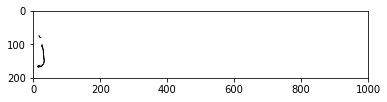

  'j' -> 'jl'


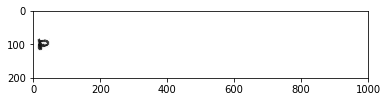

  'p' -> 'pa'


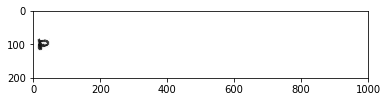

  'p' -> 'pl'
  Batch: 80 Loss: 0.21386994766071438
100


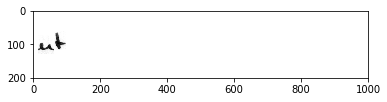

  'nt' -> 'nt<START>'


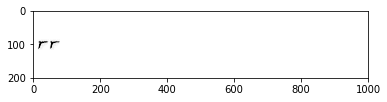

  'rr' -> 'ri<START>'


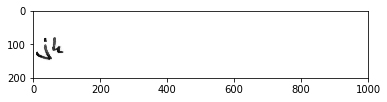

  'jk' -> 'jk<START>'
  Batch: 100 Loss: 0.239406203199178
Test loss: 0.217687
Training epoch 8...


KeyboardInterrupt: ignored

In [0]:
for i in range(0, 100):
  max_size = 3
  train(i, max_size)
  test(max_size)

Training epoch 0...
Discr loss: 1.388129
  Batch: 30 Loss: 3.0414193425575893
Discr loss: 1.387733
  Batch: 60 Loss: 2.407077549232377
Discr loss: 1.387884
  Batch: 90 Loss: 1.7427364616427157
Discr loss: 1.387885
  Batch: 120 Loss: 1.6467835028138424
Discr loss: 1.388386
  Batch: 150 Loss: 1.9173792707920072
Discr loss: 1.387893
  Batch: 180 Loss: 1.5658779889510737
Discr loss: 1.388145
  Batch: 210 Loss: 1.5328732902473872
Discr loss: 1.388755
  Batch: 240 Loss: 1.6716836119691532
Discr loss: 1.387783
  Batch: 270 Loss: 1.3991386005447974
Discr loss: 1.388117
  Batch: 300 Loss: 1.574633152567678
Discr loss: 1.388027
  Batch: 330 Loss: 1.5348963200963206
Discr loss: 1.387870
  Batch: 360 Loss: 1.619320609006617
Discr loss: 1.388182
  Batch: 390 Loss: 1.5646386592752402
Train loss: 1.785474
Discr applied 0 times.
Testing...
100


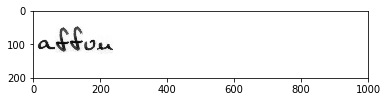

  'affvn' -> 'aqqd<STOP><START>'


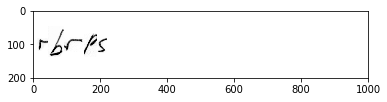

  'rbrps' -> 'rtrt<STOP><START>'


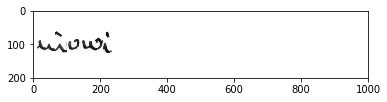

  'hivwi' -> 'hnnn<STOP><START>'
  Batch: 20 Loss: 1.4486460477982956
100


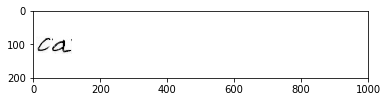

  'ca' -> 'cah'


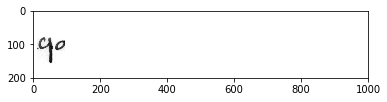

  'qo' -> 'qol'


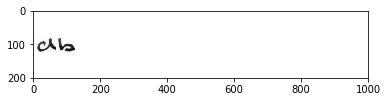

  'db' -> 'dlp'
  Batch: 40 Loss: 1.602063470768432
100


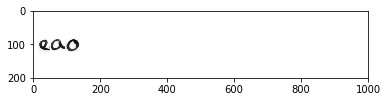

  'eao' -> 'eb<STOP><STOP>'


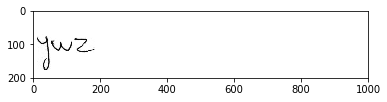

  'ywz' -> 'ywu<STOP>'


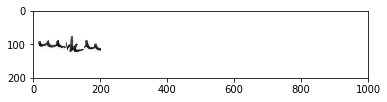

  'mkh' -> 'me<STOP><STOP>'
  Batch: 60 Loss: 1.0077912511800726
100


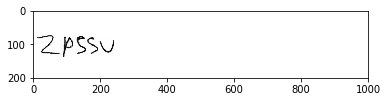

  'zpssv' -> 'zrim<STOP><START>'


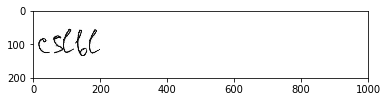

  'cslbl' -> 'cslc<STOP><START>'


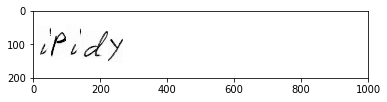

  'ipidy' -> 'ircee<START>'
  Batch: 80 Loss: 1.3501480181639391
100


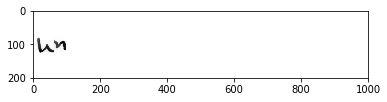

  'hn' -> 'hnx'


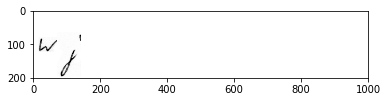

  'wj' -> 'wjd'


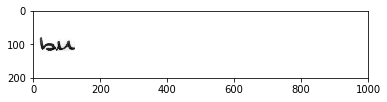

  'bu' -> 'buf'
  Batch: 100 Loss: 1.3119781045243144
Test loss: 1.330817
Training epoch 1...
Discr loss: 1.387784
  Batch: 30 Loss: 1.3891243993656508
Discr loss: 1.387946
  Batch: 60 Loss: 1.393170186479886
Discr loss: 1.388035
  Batch: 90 Loss: 1.3027717867824764
Discr loss: 1.388253
  Batch: 120 Loss: 1.3383615525397987
Discr loss: 1.388577
  Batch: 150 Loss: 1.3533837126195432
Discr loss: 1.388037
  Batch: 180 Loss: 1.3001067911419604
Discr loss: 1.387689
  Batch: 210 Loss: 1.2162600365446676
Discr loss: 1.388126
  Batch: 240 Loss: 1.28747171892888
Discr loss: 1.387842
  Batch: 270 Loss: 1.3235493655502795
Discr loss: 1.387561
  Batch: 300 Loss: 1.5332317102700472
Discr loss: 1.388184
  Batch: 330 Loss: 1.314428509953949
Discr loss: 1.388144
  Batch: 360 Loss: 1.1822654049760764
Discr loss: 1.387984
  Batch: 390 Loss: 1.4751543246457974
Train loss: 1.334275
Discr applied 0 times.
Testing...
100


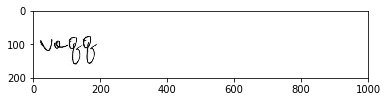

  'vaqq' -> 'vgg<STOP>z'


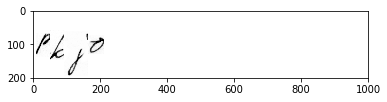

  'pkjo' -> 'phluf'


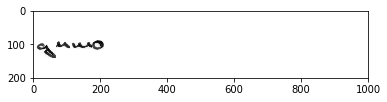

  'gnmo' -> 'gnn<STOP><STOP>'
  Batch: 20 Loss: 1.4604665491605797
100


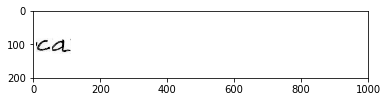

  'ca' -> 'cas'


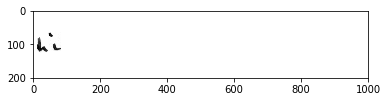

  'hi' -> 'hi<STOP>'


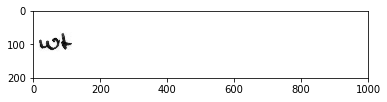

  'wt' -> 'wte'
  Batch: 40 Loss: 1.1315913528203965
100


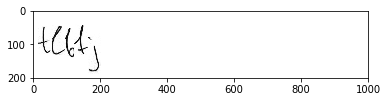

  'tlbfj' -> 'tlqq<STOP><START>'


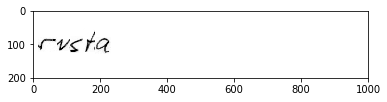

  'rvsta' -> 'rsse<STOP><START>'


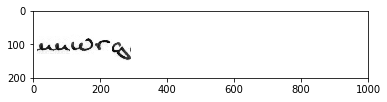

  'nnwrg' -> 'mmwz<STOP><START>'
  Batch: 60 Loss: 1.33271044810613
100


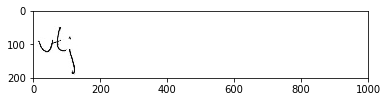

  'vtj' -> 'vljs'


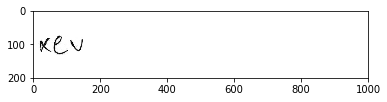

  'xev' -> 'xe<STOP>i'


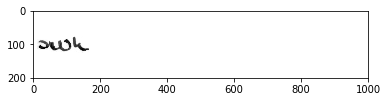

  'swk' -> 'swbi'
  Batch: 80 Loss: 0.8377273418009281
100


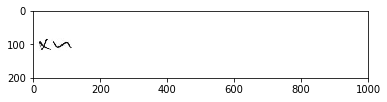

  'xn' -> 'xnc'


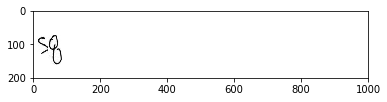

  'sq' -> 'sgx'


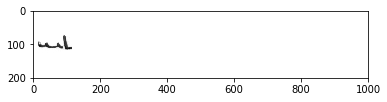

  'ml' -> 'nvz'
  Batch: 100 Loss: 1.3862565701330705
Test loss: 1.217575
Training epoch 2...
Discr loss: 1.387908
  Batch: 30 Loss: 1.2761164509091112
Discr loss: 1.387516
  Batch: 60 Loss: 1.3814734199477567
Discr loss: 1.387800
  Batch: 90 Loss: 1.3643105486532052
Discr loss: 1.387909
  Batch: 120 Loss: 1.4249909993178318
Discr loss: 1.388004
  Batch: 150 Loss: 1.3574103134373823
Discr loss: 1.387874
  Batch: 180 Loss: 1.1430215878205165
Discr loss: 1.387677
  Batch: 210 Loss: 1.1816984653390117
Discr loss: 1.387993
  Batch: 240 Loss: 1.3835660322755576
Discr loss: 1.387916
  Batch: 270 Loss: 1.1866287441551684
Discr loss: 1.387939
  Batch: 300 Loss: 1.4520709228350055
Discr loss: 1.387784
  Batch: 330 Loss: 1.1015021207845874
Discr loss: 1.388208
  Batch: 360 Loss: 1.0559198789132966
Discr loss: 1.387921
  Batch: 390 Loss: 1.2430035961502128
Train loss: 1.265403
Discr applied 0 times.
Testing...
100


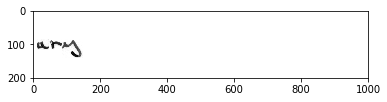

  'ury' -> 'unyp'


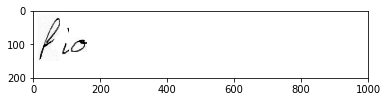

  'fio' -> 'ftep'


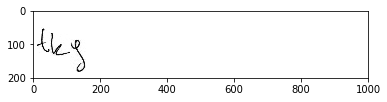

  'tkg' -> 'tkez'
  Batch: 20 Loss: 1.4091490388040742
100


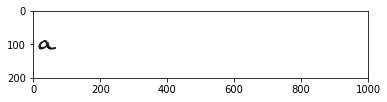

  'a' -> 'ac'


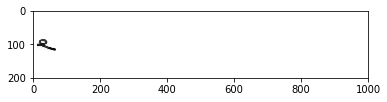

  'e' -> 'eh'


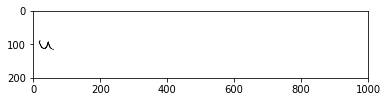

  'u' -> 'uv'
  Batch: 40 Loss: 0.9477272026240826
100


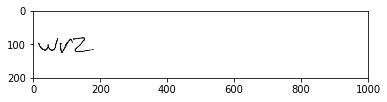

  'wrz' -> 'wtzg'


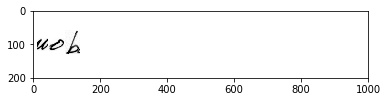

  'uob' -> 'uoqu'


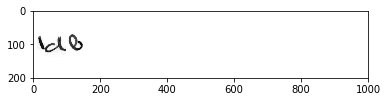

  'ldb' -> 'lgpq'
  Batch: 60 Loss: 1.0313222180803616
100


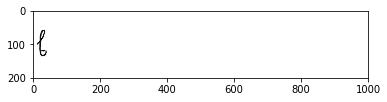

  'b' -> 'bx'


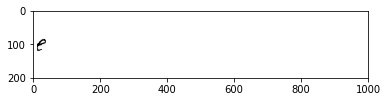

  'e' -> 'eu'


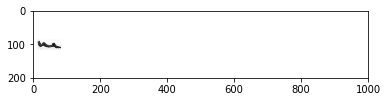

  'm' -> 'me'
  Batch: 80 Loss: 1.157541386447847
100


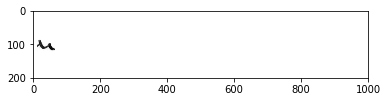

  'h' -> 'hr'


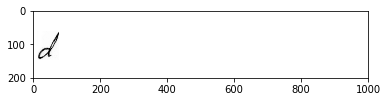

  'd' -> 'ds'


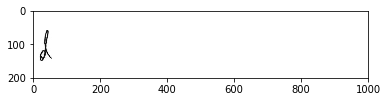

  'd' -> 'gw'
  Batch: 100 Loss: 1.098963174894452
Test loss: 1.117763
Training epoch 3...
Discr loss: 1.388070
  Batch: 30 Loss: 1.2230302378783624
Discr loss: 1.388108
  Batch: 60 Loss: 1.3165324922071564
Discr loss: 1.387800
  Batch: 90 Loss: 1.2239722329378127
Discr loss: 1.387618
  Batch: 120 Loss: 1.2528661071343556
Discr loss: 1.387774
  Batch: 150 Loss: 1.202624336414867
Discr loss: 1.387814
  Batch: 180 Loss: 1.0804788637326825
Discr loss: 1.387841
  Batch: 210 Loss: 0.9589471267163753
Discr loss: 1.387747
  Batch: 240 Loss: 0.9813064429577856
Discr loss: 1.387811
  Batch: 270 Loss: 1.1754482241471609
Discr loss: 1.387948
  Batch: 300 Loss: 1.085985223667489
Discr loss: 1.388004
  Batch: 330 Loss: 1.220789549599091
Discr loss: 1.388575
  Batch: 360 Loss: 1.1198701365871562
Discr loss: 1.388429
  Batch: 390 Loss: 1.1855038303964667
Train loss: 1.154382
Discr applied 0 times.
Testing...
100


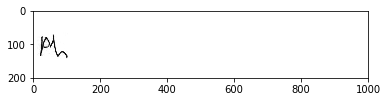

  'ph' -> 'phe'


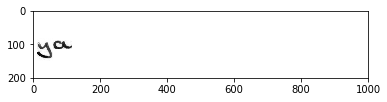

  'ya' -> 'yad'


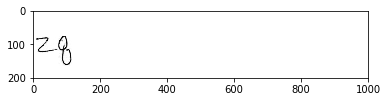

  'zq' -> 'zgt'
  Batch: 20 Loss: 0.9021638393526276
100


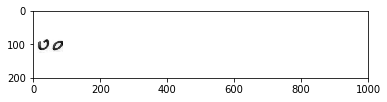

  'vo' -> 'voi'


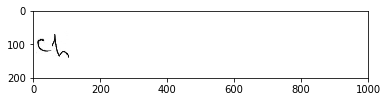

  'ch' -> 'chr'


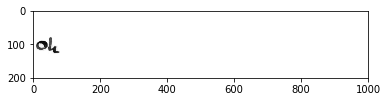

  'ok' -> 'okb'
  Batch: 40 Loss: 0.8792091775685549
100


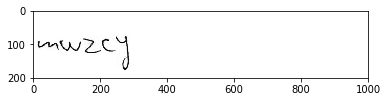

  'mwzcy' -> 'mdmy<STOP><START>'


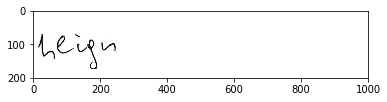

  'heign' -> 'hkvdm<START>'


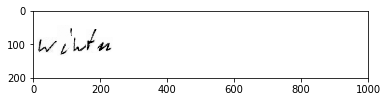

  'wiwtn' -> 'wirr<STOP><START>'
  Batch: 60 Loss: 1.21067587201794
100


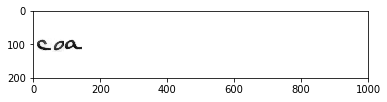

  'coa' -> 'caaa'


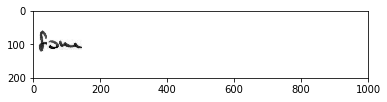

  'fsm' -> 'fnmx'


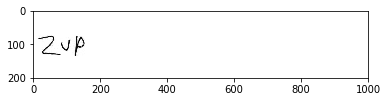

  'zvp' -> 'zyyy'
  Batch: 80 Loss: 1.020674094123145
100


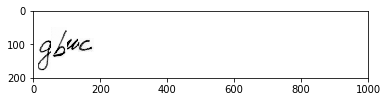

  'gbuc' -> 'dem<STOP>z'


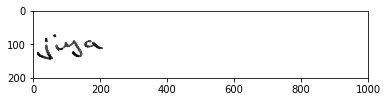

  'jiya' -> 'jvywm'


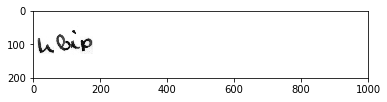

  'hbip' -> 'hbstm'
  Batch: 100 Loss: 1.1991385576501488
Test loss: 1.032052
Training epoch 4...
Discr loss: 1.387769
  Batch: 30 Loss: 1.2932144524736535
Discr loss: 1.387800
  Batch: 60 Loss: 0.9661612663749193
Discr loss: 1.387671
  Batch: 90 Loss: 0.8375807852049668
Discr loss: 1.387895
  Batch: 120 Loss: 1.1617248659249808
Discr loss: 1.388138
  Batch: 150 Loss: 1.2251765408449704
Discr loss: 1.388029
  Batch: 180 Loss: 1.0178943474342426
Discr loss: 1.388319
  Batch: 210 Loss: 0.9710229779117637
Discr loss: 1.387803
  Batch: 240 Loss: 0.9544379929039213
Discr loss: 1.388051
  Batch: 270 Loss: 0.940239498068889
Discr loss: 1.387671
  Batch: 300 Loss: 1.1580421022491327
Discr loss: 1.387892
  Batch: 330 Loss: 1.071950846678681
Discr loss: 1.388227
  Batch: 360 Loss: 1.1069938901397918
Discr loss: 1.387657
  Batch: 390 Loss: 0.8436189206689596
Train loss: 1.045682
Discr applied 0 times.
Testing...
100


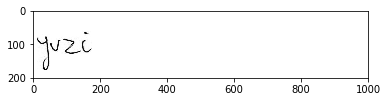

  'yvzi' -> 'yrz<STOP><STOP>'


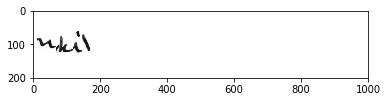

  'ukil' -> 'vktpv'


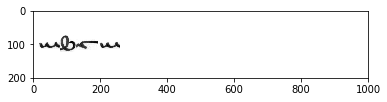

  'mbrm' -> 'mqeml'
  Batch: 20 Loss: 0.9907175369684896
100


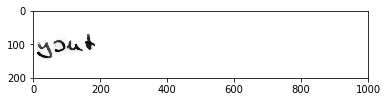

  'yskt' -> 'yokym'


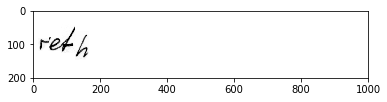

  'reth' -> 'rbf<STOP>t'


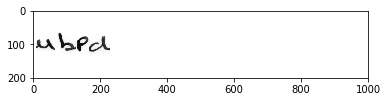

  'ubpd' -> 'ubgwn'
  Batch: 40 Loss: 1.0436839641133944
100


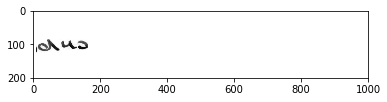

  'dus' -> 'duiw'


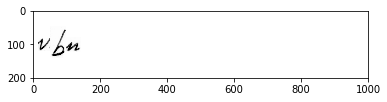

  'vbn' -> 'vbwk'


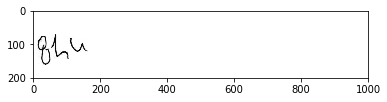

  'qhu' -> 'qhuw'
  Batch: 60 Loss: 0.879707099708418
100


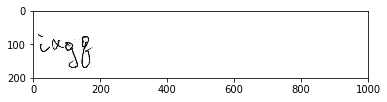

  'ixgq' -> 'igggs'


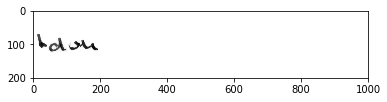

  'tdvh' -> 'tdss<STOP>'


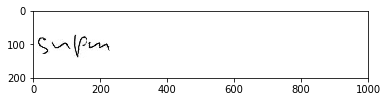

  'snpm' -> 'snuzw'
  Batch: 80 Loss: 1.1816357037300864
100


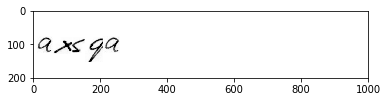

  'axsqa' -> 'axxgz<START>'


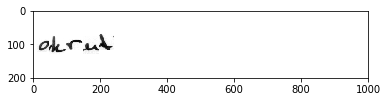

  'okrnt' -> 'okrmc<START>'


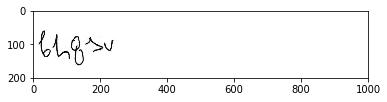

  'bhqsv' -> 'bhtkg<START>'
  Batch: 100 Loss: 1.1283209513376158
Test loss: 1.034468
Training epoch 5...
Discr loss: 1.388112
  Batch: 30 Loss: 1.326797502256102
Discr loss: 1.387782
  Batch: 60 Loss: 1.1429395726654263
Discr loss: 1.387804
  Batch: 90 Loss: 1.210246950851546
Discr loss: 1.388096
  Batch: 120 Loss: 1.0248044822778968
Discr loss: 1.387715
  Batch: 150 Loss: 0.8991618891888195
Discr loss: 1.387837
  Batch: 180 Loss: 0.9035714459212288
Discr loss: 1.387855
  Batch: 210 Loss: 1.0951246517399946
Discr loss: 1.387897
  Batch: 240 Loss: 1.155835635413726
Discr loss: 1.387765
  Batch: 270 Loss: 0.8908595942747262
Discr loss: 1.387789
  Batch: 300 Loss: 0.9835364429901043
Discr loss: 1.387837
  Batch: 330 Loss: 0.9919410261097882
Discr loss: 1.387978
  Batch: 360 Loss: 0.8179822199088005
Discr loss: 1.387759
  Batch: 390 Loss: 1.0705908255941339
Train loss: 1.036460
Discr applied 0 times.
Testing...
100


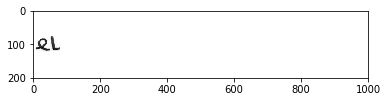

  'el' -> 'elk'


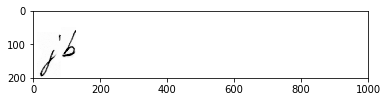

  'jb' -> 'jjh'


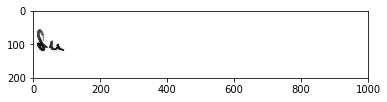

  'fk' -> 'fkx'
  Batch: 20 Loss: 1.1429542273034654
100


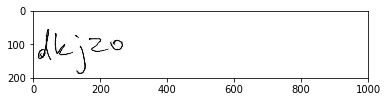

  'dkjzo' -> 'dkizf<START>'


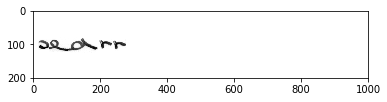

  'sedrr' -> 'sedca<START>'


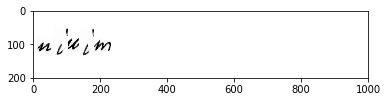

  'niuim' -> 'nwwnn<START>'
  Batch: 40 Loss: 0.6949213493242861
100


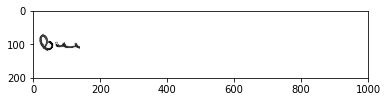

  'bm' -> 'bmj'


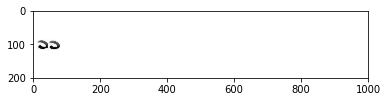

  'ss' -> 'ssq'


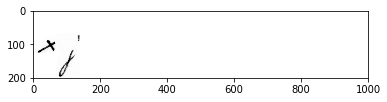

  'xj' -> 'xjy'
  Batch: 60 Loss: 0.8090741648276648
100


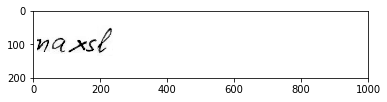

  'naxsl' -> 'nojjy<START>'


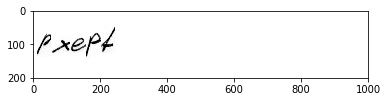

  'pxept' -> 'pxgg<STOP><START>'


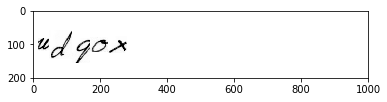

  'udqox' -> 'udxxm<START>'
  Batch: 80 Loss: 0.9184924024281402
100


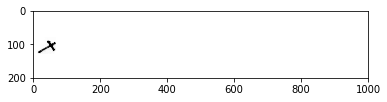

  'x' -> 'xf'


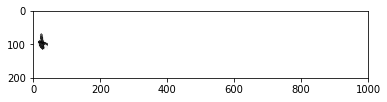

  't' -> 'to'


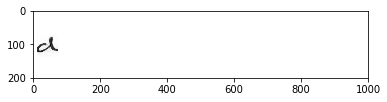

  'd' -> 'da'
  Batch: 100 Loss: 0.7247493071481586
Test loss: 0.849543
Training epoch 6...
Discr loss: 1.387734
  Batch: 30 Loss: 1.113594957722558
Discr loss: 1.387801
  Batch: 60 Loss: 1.0556817684322595
Discr loss: 1.387441
  Batch: 90 Loss: 0.9651675871180164
Discr loss: 1.387789
  Batch: 120 Loss: 1.035020399797294
Discr loss: 1.387754
  Batch: 150 Loss: 0.8450541976425382
Discr loss: 1.387266
  Batch: 180 Loss: 1.036354637088047
Discr loss: 1.387728
  Batch: 210 Loss: 0.7488402022255792
Discr loss: 1.387932
  Batch: 240 Loss: 0.9499607526924874
Discr loss: 1.388000
  Batch: 270 Loss: 0.8814920584443543
Discr loss: 1.388232
  Batch: 300 Loss: 0.9399354812585645
Discr loss: 1.388159
  Batch: 330 Loss: 1.0715976828750635
Discr loss: 1.387741
  Batch: 360 Loss: 1.1616264955906404
Discr loss: 1.388150
  Batch: 390 Loss: 0.6842982335471445
Train loss: 0.957864
Discr applied 0 times.
Testing...
100


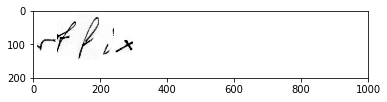

  'rffix' -> 'rfjyd<START>'


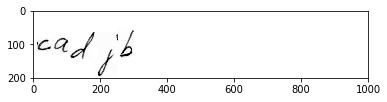

  'cadjb' -> 'cadqq<START>'


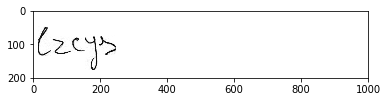

  'lzcys' -> 'lzxyx<START>'
  Batch: 20 Loss: 1.029794342275709
100


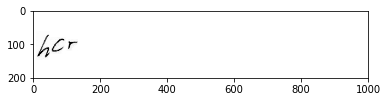

  'hcr' -> 'rcrd'


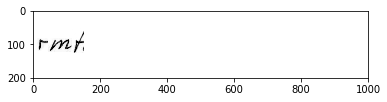

  'rmt' -> 'rmtn'


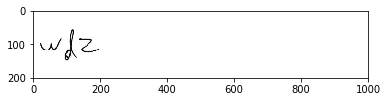

  'wdz' -> 'wdzy'
  Batch: 40 Loss: 1.0276862716736894
100


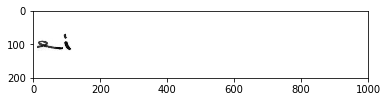

  'ei' -> 'erp'


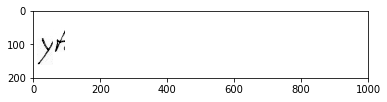

  'yt' -> 'ypg'


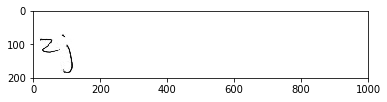

  'zj' -> 'zjj'
  Batch: 60 Loss: 1.005872325350841
100


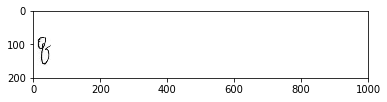

  'q' -> 'qs'


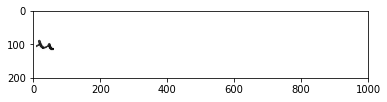

  'h' -> 'ha'


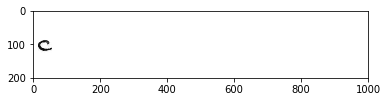

  'c' -> 'cq'
  Batch: 80 Loss: 0.9974809015418092
100


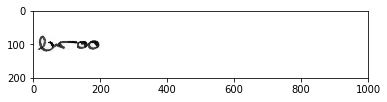

  'broo' -> 'bror<STOP>'


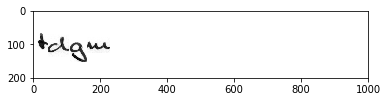

  'tdgm' -> 'tdgm<STOP>'


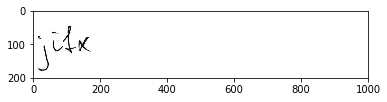

  'jifx' -> 'jitid'
  Batch: 100 Loss: 1.0271364574755233
Test loss: 1.007519
Training epoch 7...
Discr loss: 1.387765
  Batch: 30 Loss: 1.023138823914859
Discr loss: 1.387737
  Batch: 60 Loss: 1.1823209583676522
Discr loss: 1.388306
  Batch: 90 Loss: 1.2462631213665007
Discr loss: 1.387844
  Batch: 120 Loss: 0.8542779763208496
Discr loss: 1.388005
  Batch: 150 Loss: 0.9417323621362447
Discr loss: 1.388101
  Batch: 180 Loss: 1.1591412214355337
Discr loss: 1.388071
  Batch: 210 Loss: 0.912783073882262
Discr loss: 1.388001
  Batch: 240 Loss: 0.8555260913239585
Discr loss: 1.387761
  Batch: 270 Loss: 0.6755721851438284
Discr loss: 1.387835
  Batch: 300 Loss: 1.068030427388019
Discr loss: 1.387967
  Batch: 330 Loss: 0.8235482249077823
Discr loss: 1.387839
  Batch: 360 Loss: 0.8367842658691935
Discr loss: 1.387835
  Batch: 390 Loss: 0.899425532416337
Train loss: 0.959175
Discr applied 0 times.
Testing...
100


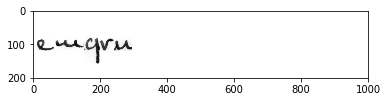

  'emqru' -> 'entie<START>'


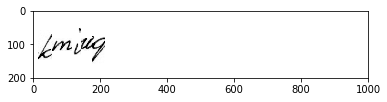

  'kmiuq' -> 'kmlpp<START>'


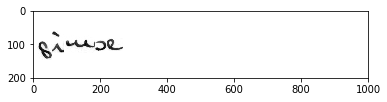

  'gimse' -> 'gcmcc<START>'
  Batch: 20 Loss: 0.9726988699721794
100


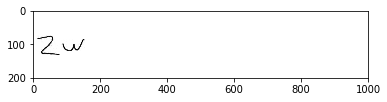

  'zw' -> 'zzo'


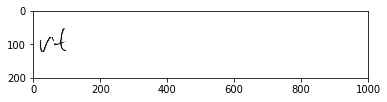

  'rt' -> 'rtn'


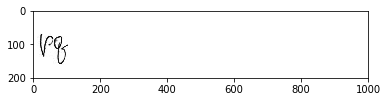

  'pq' -> 'pqk'
  Batch: 40 Loss: 0.9514902759405475
100


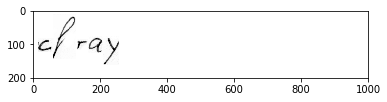

  'cfray' -> 'clrrp<START>'


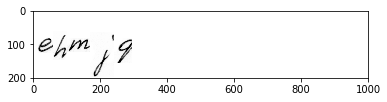

  'ehmjq' -> 'ehwjq<START>'


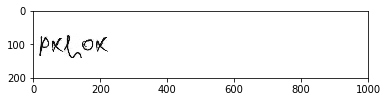

  'pxhox' -> 'hxpsv<START>'
  Batch: 60 Loss: 0.9378686843688289
100


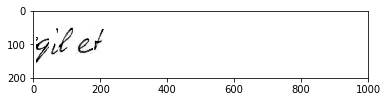

  'qilet' -> 'qitrr<START>'


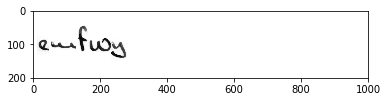

  'emfwy' -> 'embff<START>'


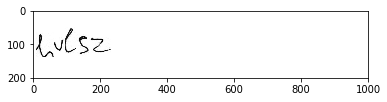

  'hvlsz' -> 'hjtzz<START>'
  Batch: 80 Loss: 0.7764240482884149
100


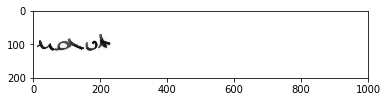

  'hdvt' -> 'hoosx'


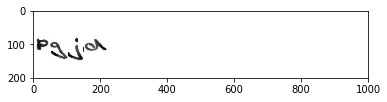

  'pgjd' -> 'pgygr'


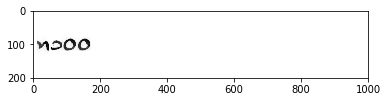

  'nsoo' -> 'nsost'
  Batch: 100 Loss: 1.071252944978575
Test loss: 0.932621
Training epoch 8...
Discr loss: 1.387799
  Batch: 30 Loss: 0.8787895202678109
Discr loss: 1.387757
  Batch: 60 Loss: 0.9053910011715358
Discr loss: 1.387811
  Batch: 90 Loss: 0.8971016589841909
Discr loss: 1.388005
  Batch: 120 Loss: 1.0012311551388768
Discr loss: 1.387680
  Batch: 150 Loss: 0.9416644304162926
Discr loss: 1.388184
  Batch: 180 Loss: 0.8876666148420838
Discr loss: 1.387840
  Batch: 210 Loss: 0.8975886721163988
Discr loss: 1.387789
  Batch: 240 Loss: 0.759027053370244
Discr loss: 1.387685
  Batch: 270 Loss: 1.003907846522828
Discr loss: 1.388389
  Batch: 300 Loss: 1.0391105295717717
Discr loss: 1.388142
  Batch: 330 Loss: 0.9045735714667373
Discr loss: 1.387703
  Batch: 360 Loss: 0.8507744442216223
Discr loss: 1.387905
  Batch: 390 Loss: 0.8380376219252745
Train loss: 0.916084
Discr applied 0 times.
Testing...
100


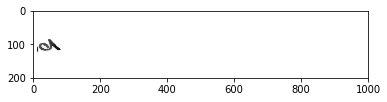

  'd' -> 'dk'


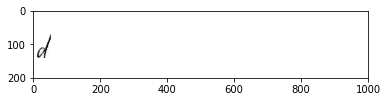

  'd' -> 'do'


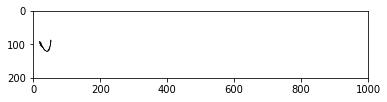

  'v' -> 'vt'
  Batch: 20 Loss: 0.8953877865274746
100


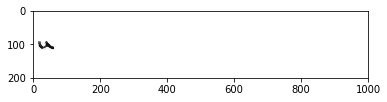

  'u' -> 'uc'


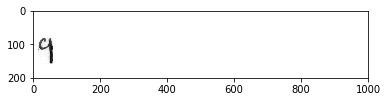

  'q' -> 'qm'


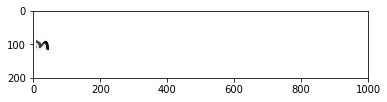

  'n' -> 'nb'
  Batch: 40 Loss: 0.8271718673470121
100


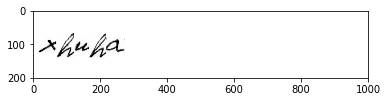

  'xhuha' -> 'xhkkz<START>'


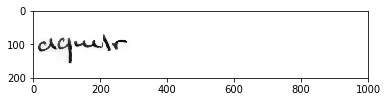

  'dqmlr' -> 'dpmkc<START>'


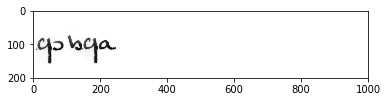

  'qsbqa' -> 'qcllc<START>'
  Batch: 60 Loss: 0.9194991852156816
100


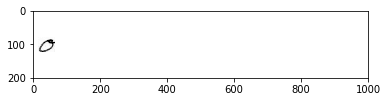

  'o' -> 'ob'


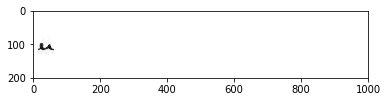

  'n' -> 'nb'


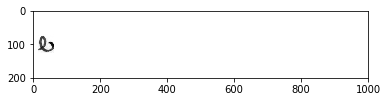

  'b' -> 'bz'
  Batch: 80 Loss: 0.7217690579531093
100


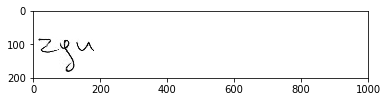

  'zgu' -> 'zdwm'


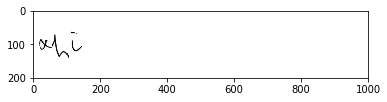

  'xhi' -> 'xhkj'


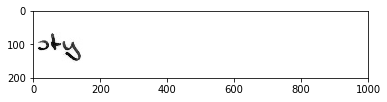

  'sty' -> 'stgq'
  Batch: 100 Loss: 0.6541876821406185
Test loss: 0.795647
Training epoch 9...
Discr loss: 1.387811
  Batch: 30 Loss: 0.8437866331140199
Discr loss: 1.387663
  Batch: 60 Loss: 0.7696875565002361
Discr loss: 1.387918
  Batch: 90 Loss: 0.8579990197014478
Discr loss: 1.388054
  Batch: 120 Loss: 0.9138443025863835
Discr loss: 1.387825
  Batch: 150 Loss: 0.8564886151295571
Discr loss: 1.388007
  Batch: 180 Loss: 0.7223167512151929
Discr loss: 1.387944
  Batch: 210 Loss: 1.015773801824285
Discr loss: 1.388088
  Batch: 240 Loss: 0.902333978642192
Discr loss: 1.388040
  Batch: 270 Loss: 0.8302874206337663
Discr loss: 1.387814
  Batch: 300 Loss: 0.9855253661837844
Discr loss: 1.387798
  Batch: 330 Loss: 0.8216836205124856
Discr loss: 1.388000
  Batch: 360 Loss: 0.9004061263220178
Discr loss: 1.387737
  Batch: 390 Loss: 1.000976322318117
Train loss: 0.874094
Discr applied 0 times.
Testing...
100


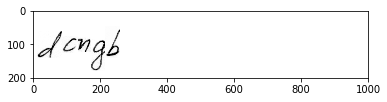

  'dcngb' -> 'drwqq<START>'


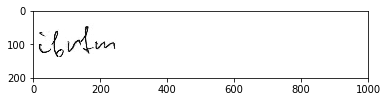

  'ibrfm' -> 'ibrhm<START>'


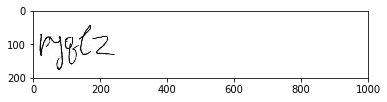

  'pyqlz' -> 'pybkz<START>'
  Batch: 20 Loss: 0.8903593581480285
100


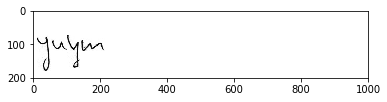

  'yuym' -> 'yuymt'


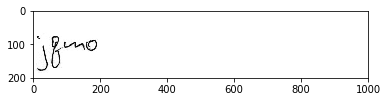

  'jqmo' -> 'jqmsx'


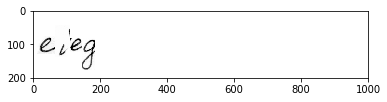

  'eieg' -> 'eiefs'
  Batch: 40 Loss: 0.8344189079788824
100


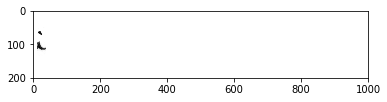

  'i' -> 'ij'


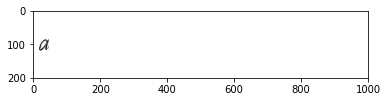

  'a' -> 'ax'


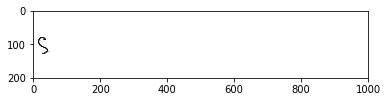

  's' -> 'sz'
  Batch: 60 Loss: 1.0050296703539787
100


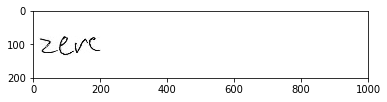

  'zerc' -> 'ztrsz'


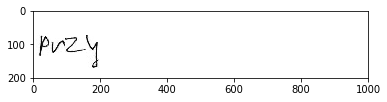

  'przy' -> 'przfr'


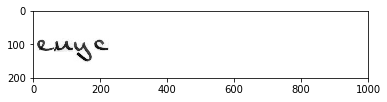

  'euyc' -> 'ewybv'
  Batch: 80 Loss: 0.9326142790168523
100


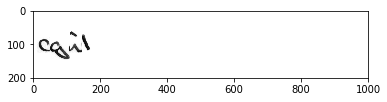

  'cgil' -> 'cgilv'


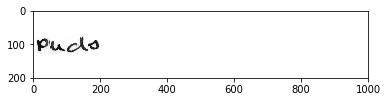

  'pkds' -> 'pkdv<STOP>'


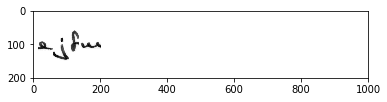

  'ejfm' -> 'kjhnb'
  Batch: 100 Loss: 0.8731402997983
Test loss: 0.898131
Training epoch 10...
Discr loss: 1.388062
  Batch: 30 Loss: 0.7552194857266215
Discr loss: 1.387836
  Batch: 60 Loss: 0.8848683856179317
Discr loss: 1.387994
  Batch: 90 Loss: 1.15431494253791
Discr loss: 1.387656
  Batch: 120 Loss: 1.0235550211618343
Discr loss: 1.387812
  Batch: 150 Loss: 1.0179923649628957
Discr loss: 1.387778
  Batch: 180 Loss: 0.9365909758955241
Discr loss: 1.387887
  Batch: 210 Loss: 0.9143837630210654
Discr loss: 1.387862
  Batch: 240 Loss: 0.7940672906984886
Discr loss: 1.387787
  Batch: 270 Loss: 0.9221052445471287
Discr loss: 1.388229
  Batch: 300 Loss: 0.873078846314715
Discr loss: 1.387900
  Batch: 330 Loss: 1.034862504195836
Discr loss: 1.388016
  Batch: 360 Loss: 0.9542462988777294
Discr loss: 1.387737
  Batch: 390 Loss: 0.8133065580245521
Train loss: 0.935029
Discr applied 0 times.
Testing...
100


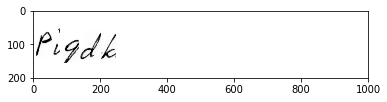

  'piqdk' -> 'piqdw<START>'


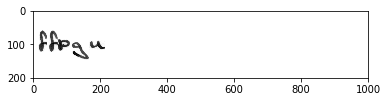

  'ffpgu' -> 'fpvvv<START>'


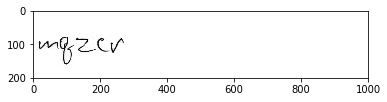

  'mqzcr' -> 'mxziv<START>'
  Batch: 20 Loss: 1.0960320603785416
100


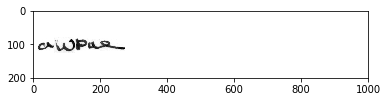

  'awpue' -> 'awpnn<START>'


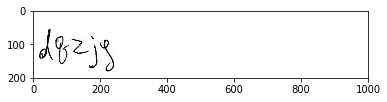

  'dqzjg' -> 'dgzjd<START>'


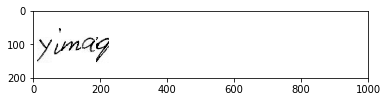

  'yimaq' -> 'ynmel<START>'
  Batch: 40 Loss: 1.0722888713702559
100


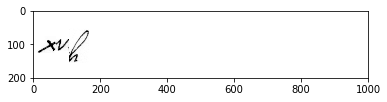

  'xvh' -> 'xvhw'


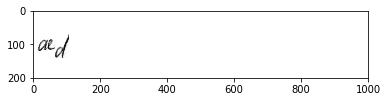

  'aed' -> 'avvo'


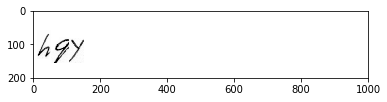

  'hqy' -> 'hqyn'
  Batch: 60 Loss: 0.8540032592974602
100


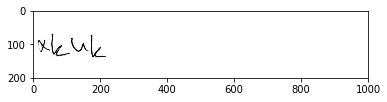

  'xkuk' -> 'xkuxn'


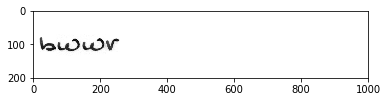

  'bwwr' -> 'bwosc'


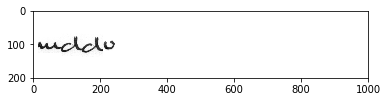

  'mddv' -> 'moesf'
  Batch: 80 Loss: 0.6806331740257641
100


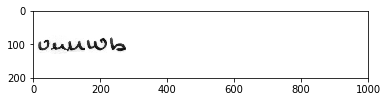

  'vnuwb' -> 'vmwwd<START>'


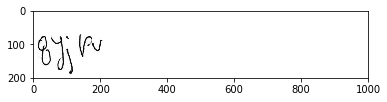

  'qyjpv' -> 'pvjpj<START>'


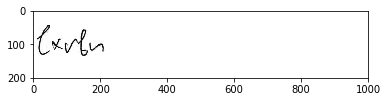

  'lxrbn' -> 'lxpft<START>'
  Batch: 100 Loss: 0.8049183087423444
Test loss: 0.892649
Training epoch 11...
Discr loss: 1.387785
  Batch: 30 Loss: 0.7895861017290089
Discr loss: 1.388255
  Batch: 60 Loss: 0.8159438589711985
Discr loss: 1.387859
  Batch: 90 Loss: 0.6290828403126861
Discr loss: 1.387811
  Batch: 120 Loss: 0.7633473190706638
Discr loss: 1.387894
  Batch: 150 Loss: 0.8420610759697026
Discr loss: 1.387825
  Batch: 180 Loss: 0.7648497686824866
Discr loss: 1.388223
  Batch: 210 Loss: 0.8953445974571838
Discr loss: 1.387794
  Batch: 240 Loss: 0.6205906463828351
Discr loss: 1.387614
  Batch: 270 Loss: 0.8054990007314417
Discr loss: 1.387843
  Batch: 300 Loss: 0.774872957939903
Discr loss: 1.387978
  Batch: 330 Loss: 0.8834452908734481
Discr loss: 1.388140
  Batch: 360 Loss: 0.761171952088674
Discr loss: 1.387864
  Batch: 390 Loss: 0.8030066624490751
Train loss: 0.779668
Discr applied 0 times.
Testing...
100


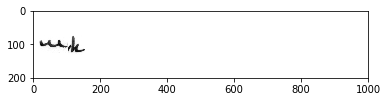

  'mk' -> 'mke'


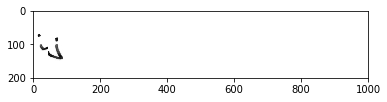

  'ij' -> 'ijf'


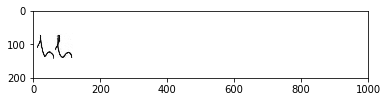

  'hh' -> 'hhf'
  Batch: 20 Loss: 1.1639110901703436
100


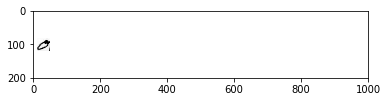

  'o' -> 'oy'


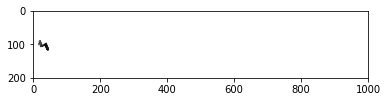

  'n' -> 'nn'


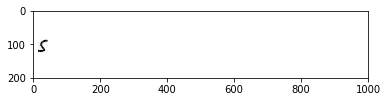

  's' -> 'sj'
  Batch: 40 Loss: 0.879441488198936
100


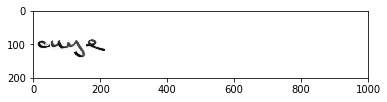

  'ouye' -> 'owynw'


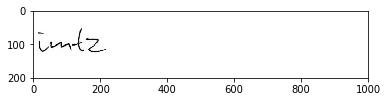

  'imtz' -> 'imbze'


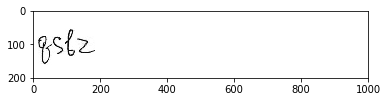

  'qsbz' -> 'qsbce'
  Batch: 60 Loss: 1.0421868336883686
100


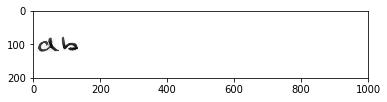

  'db' -> 'dfy'


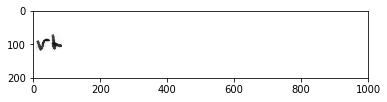

  'rt' -> 'rto'


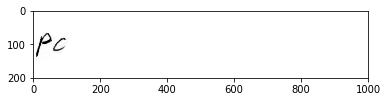

  'pc' -> 'pcb'
  Batch: 80 Loss: 0.6729244911422332
100


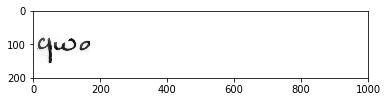

  'qwo' -> 'qnog'


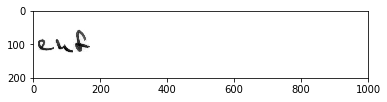

  'ehf' -> 'elfm'


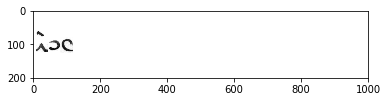

  'isc' -> 'ixsg'
  Batch: 100 Loss: 0.7143441060744226
Test loss: 0.885705
Training epoch 12...
Discr loss: 1.387717
  Batch: 30 Loss: 0.6404216039429108
Discr loss: 1.387763
  Batch: 60 Loss: 0.6909746728920274
Discr loss: 1.387836
  Batch: 90 Loss: 0.6505665010544989
Discr loss: 1.388137
  Batch: 120 Loss: 0.8878137901425363
Discr loss: 1.387767
  Batch: 150 Loss: 0.6981469077865284
Discr loss: 1.388059
  Batch: 180 Loss: 0.7909655408230094
Discr loss: 1.387796
  Batch: 210 Loss: 0.7581864663089316
Discr loss: 1.387814
  Batch: 240 Loss: 0.7211810964470108
Discr loss: 1.387944
  Batch: 270 Loss: 0.7369126465875241
Discr loss: 1.387844
  Batch: 300 Loss: 0.7912047950757876
Discr loss: 1.387749
  Batch: 330 Loss: 0.7027524040142695
Discr loss: 1.388208
  Batch: 360 Loss: 0.5374371322575543
Discr loss: 1.387967
  Batch: 390 Loss: 0.839367509049674
Train loss: 0.725095
Discr applied 0 times.
Testing...
100


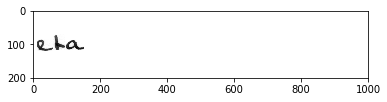

  'eta' -> 'etan'


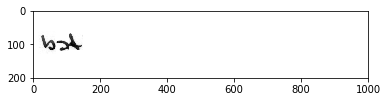

  'bst' -> 'bste'


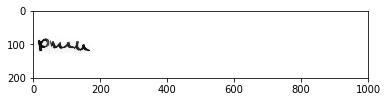

  'pmk' -> 'pmhf'
  Batch: 20 Loss: 0.8524237819326419
100


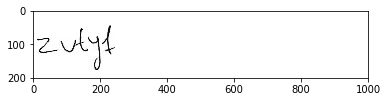

  'zvtyf' -> 'zvtjf<START>'


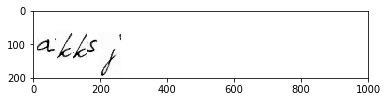

  'akksj' -> 'akkql<START>'


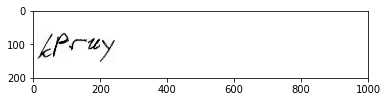

  'kpruy' -> 'kprxx<START>'
  Batch: 40 Loss: 0.6988697473766903
100


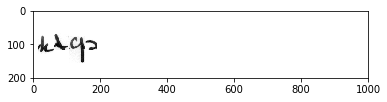

  'ktqs' -> 'ktpvv'


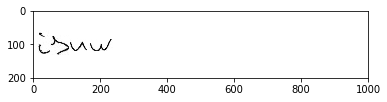

  'isuw' -> 'iswwf'


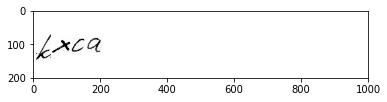

  'kxca' -> 'kxcxc'
  Batch: 60 Loss: 0.8375382532676061
100


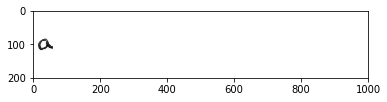

  'a' -> 'ah'


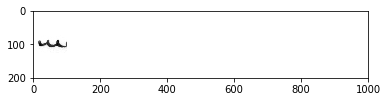

  'm' -> 'mf'


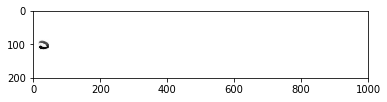

  's' -> 'sh'
  Batch: 80 Loss: 0.8572913537298639
100


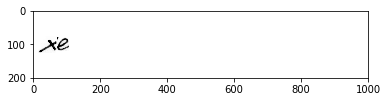

  'xe' -> 'xeh'


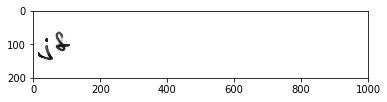

  'jf' -> 'jfn'


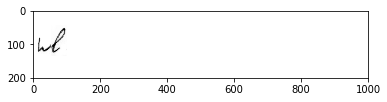

  'wl' -> 'wlj'
  Batch: 100 Loss: 0.7091322831623256
Test loss: 0.783219
Training epoch 13...
Discr loss: 1.387831
  Batch: 30 Loss: 0.6636628711678916
Discr loss: 1.388194
  Batch: 60 Loss: 0.8565008267843062
Discr loss: 1.388229
  Batch: 90 Loss: 0.833152891157402
Discr loss: 1.387809
  Batch: 120 Loss: 0.8906172331919272
Discr loss: 1.388180
  Batch: 150 Loss: 0.7843315988323756
Discr loss: 1.387734
  Batch: 180 Loss: 0.8795672852794328
Discr loss: 1.387979
  Batch: 210 Loss: 0.6384169627022412
Discr loss: 1.387894
  Batch: 240 Loss: 0.669982048322757
Discr loss: 1.388143
  Batch: 270 Loss: 0.671121918256912
Discr loss: 1.387810
  Batch: 300 Loss: 0.6930610367862716
Discr loss: 1.387923
  Batch: 330 Loss: 0.684756457331694
Discr loss: 1.388301
  Batch: 360 Loss: 0.7493615358902349
Discr loss: 1.387856
  Batch: 390 Loss: 0.6044012251661884
Train loss: 0.736408
Discr applied 0 times.
Testing...
100


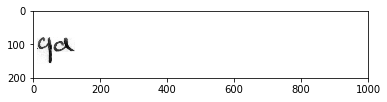

  'qd' -> 'qda'


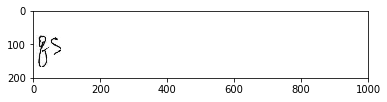

  'qs' -> 'qsa'


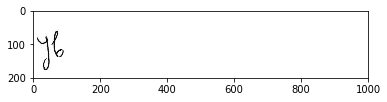

  'yb' -> 'yba'
  Batch: 20 Loss: 0.9271578160425028
100


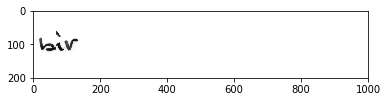

  'bir' -> 'bisj'


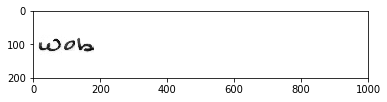

  'wob' -> 'wody'


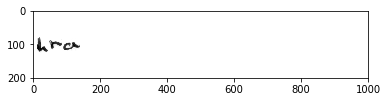

  'hra' -> 'hras'
  Batch: 40 Loss: 0.7949668204287688
100


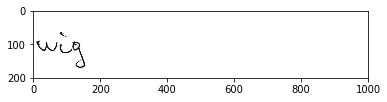

  'wig' -> 'wzdy'


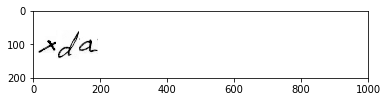

  'xda' -> 'xdzu'


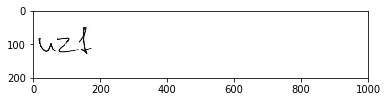

  'uzf' -> 'uzex'
  Batch: 60 Loss: 0.49013586198290193
100


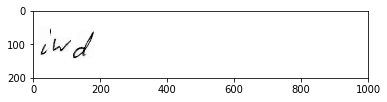

  'iwd' -> 'iwdz'


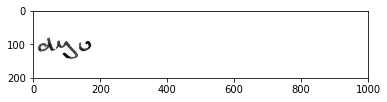

  'dyv' -> 'duit'


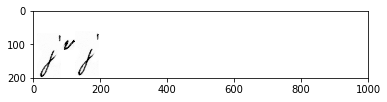

  'jvj' -> 'jvjt'
  Batch: 80 Loss: 0.6830720055227478
100


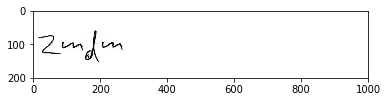

  'zmdm' -> 'zmmmq'


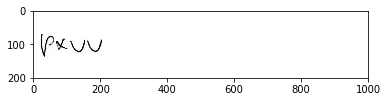

  'pxvv' -> 'pxvva'


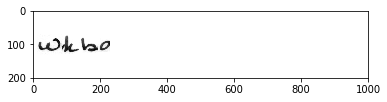

  'wkbo' -> 'weben'
  Batch: 100 Loss: 0.6798292873054742
Test loss: 0.707953
Training epoch 14...
Discr loss: 1.387777
  Batch: 30 Loss: 0.6135004164485468
Discr loss: 1.387995
  Batch: 60 Loss: 0.8066858240299755
Discr loss: 1.388126
  Batch: 90 Loss: 0.8388458175129361
Discr loss: 1.388174
  Batch: 120 Loss: 0.7770101956029732
Discr loss: 1.387800
  Batch: 150 Loss: 0.8572045367542241
Discr loss: 1.387793
  Batch: 180 Loss: 0.8654909750198325
Discr loss: 1.387820
  Batch: 210 Loss: 0.6472612530200017
Discr loss: 1.387929
  Batch: 240 Loss: 0.7903939878195524
Discr loss: 1.387800
  Batch: 270 Loss: 0.7813292447725932
Discr loss: 1.387818
  Batch: 300 Loss: 0.6251702870304386
Discr loss: 1.387731
  Batch: 330 Loss: 0.5830728353187441
Discr loss: 1.387917
  Batch: 360 Loss: 0.6184754832751221
Discr loss: 1.387952
  Batch: 390 Loss: 0.7713334308067957
Train loss: 0.736862
Discr applied 0 times.
Testing...
100


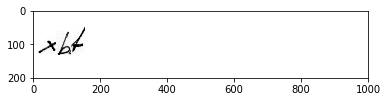

  'xbt' -> 'xbtm'


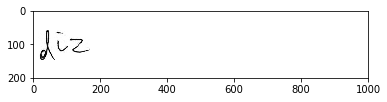

  'diz' -> 'dizn'


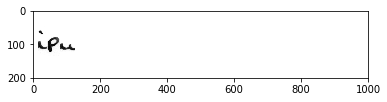

  'ipn' -> 'idnv'
  Batch: 20 Loss: 0.6460664550277094
100


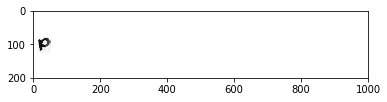

  'p' -> 'pv'


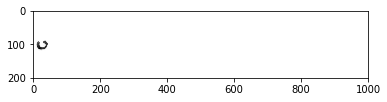

  'v' -> 'vj'


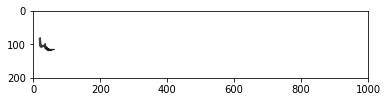

  'k' -> 'kb'
  Batch: 40 Loss: 0.5866799796993534
100


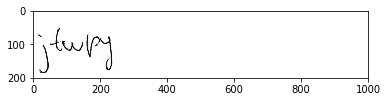

  'jtwpy' -> 'jkyyy<START>'


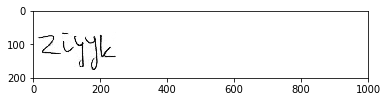

  'ziyyk' -> 'ziyle<START>'


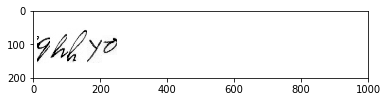

  'qhhyo' -> 'qhhpo<START>'
  Batch: 60 Loss: 0.9550096397598585
100


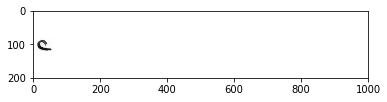

  'c' -> 'ch'


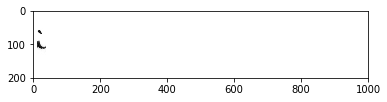

  'i' -> 'is'


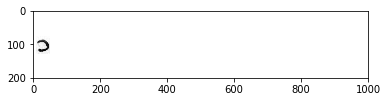

  's' -> 'sv'
  Batch: 80 Loss: 0.5039986891858279
100


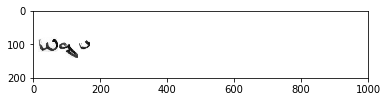

  'wgv' -> 'wgli'


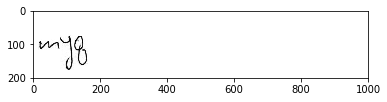

  'myq' -> 'mqqf'


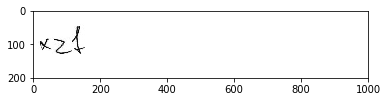

  'xzf' -> 'xzfg'
  Batch: 100 Loss: 0.6060025135676066
Test loss: 0.653021
Training epoch 15...
Discr loss: 1.387872
  Batch: 30 Loss: 0.7093502662703395
Discr loss: 1.387921
  Batch: 60 Loss: 0.6318954798827571
Discr loss: 1.387836
  Batch: 90 Loss: 0.8674474705548749
Discr loss: 1.388219
  Batch: 120 Loss: 0.8489065896471342
Discr loss: 1.387855
  Batch: 150 Loss: 0.7055546900464429
Discr loss: 1.387775
  Batch: 180 Loss: 0.8743301751630174
Discr loss: 1.387759
  Batch: 210 Loss: 0.8784230802373754
Discr loss: 1.387817
  Batch: 240 Loss: 1.0139176538462438
Discr loss: 1.387712
  Batch: 270 Loss: 1.3165905608733495
Discr loss: 1.387917
  Batch: 300 Loss: 1.093967443406582
Discr loss: 1.387892
  Batch: 330 Loss: 0.8604209502538046
Discr loss: 1.387899
  Batch: 360 Loss: 0.8442450460212098
Discr loss: 1.387773
  Batch: 390 Loss: 0.7814403495523664
Train loss: 0.876643
Discr applied 0 times.
Testing...
100


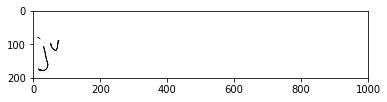

  'jv' -> 'jvd'


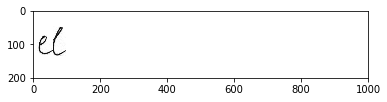

  'el' -> 'elj'


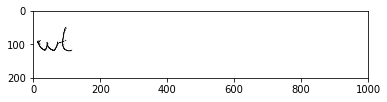

  'wt' -> 'wtc'
  Batch: 20 Loss: 1.025679623981317
100


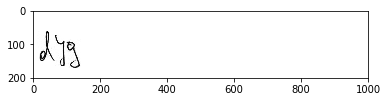

  'dyg' -> 'dygw'


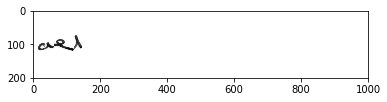

  'ael' -> 'atlc'


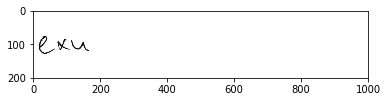

  'exu' -> 'exus'
  Batch: 40 Loss: 0.8592749194552501
100


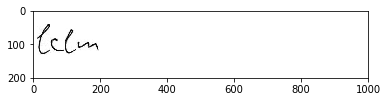

  'lclm' -> 'liwmq'


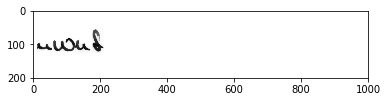

  'nwkf' -> 'nwkqn'


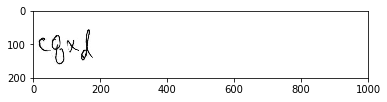

  'cqxd' -> 'cqxww'
  Batch: 60 Loss: 0.8115451577926673
100


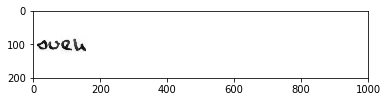

  'sveh' -> 'sukhz'


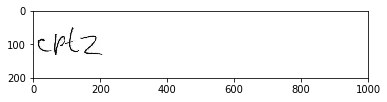

  'cptz' -> 'cpizj'


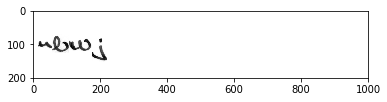

  'nbwj' -> 'nbwlv'
  Batch: 80 Loss: 0.8399533593157926
100


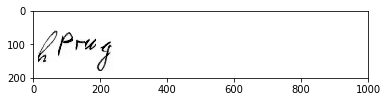

  'hprug' -> 'hjxdq<START>'


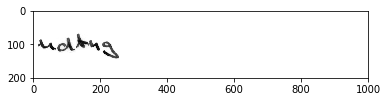

  'hdtng' -> 'hdlhl<START>'


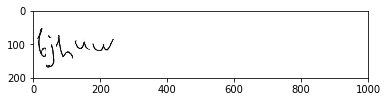

  'bjhuw' -> 'lywuw<START>'
  Batch: 100 Loss: 0.6599518699447314
Test loss: 0.830971
Training epoch 16...
Discr loss: 1.387807
  Batch: 30 Loss: 0.8039185444513957
Discr loss: 1.387854
  Batch: 60 Loss: 1.0210718350940282
Discr loss: 1.387784
  Batch: 90 Loss: 0.8941644176261291
Discr loss: 1.387876
  Batch: 120 Loss: 0.7577583390557103
Discr loss: 1.388008
  Batch: 150 Loss: 0.7399213924590082
Discr loss: 1.387987
  Batch: 180 Loss: 0.8156243564022911
Discr loss: 1.387794
  Batch: 210 Loss: 0.701724224868748
Discr loss: 1.388262
  Batch: 240 Loss: 0.6274821440047688
Discr loss: 1.388267
  Batch: 270 Loss: 0.5289919421076774
Discr loss: 1.387929
  Batch: 300 Loss: 0.7311620941923724
Discr loss: 1.388336
  Batch: 330 Loss: 0.636493764726652
Discr loss: 1.388153
  Batch: 360 Loss: 0.718347958036595
Discr loss: 1.387796
  Batch: 390 Loss: 0.7387015673766534
Train loss: 0.744007
Discr applied 0 times.
Testing...
100


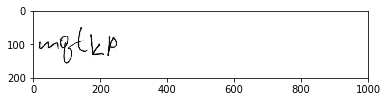

  'mqtkp' -> 'mqkzd<START>'


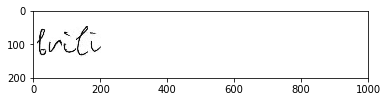

  'brili' -> 'brikn<START>'


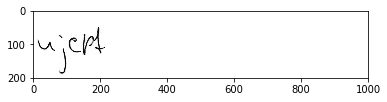

  'ujcpf' -> 'uxcqq<START>'
  Batch: 20 Loss: 0.7573885378117363
100


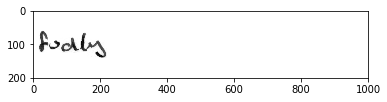

  'fvdly' -> 'fxyyv<START>'


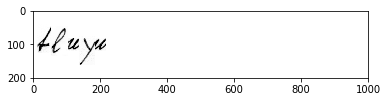

  'tluyu' -> 'tluwu<START>'


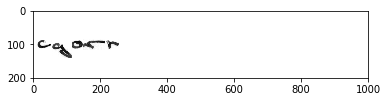

  'cgorr' -> 'cgoaa<START>'
  Batch: 40 Loss: 0.7552445306504767
100


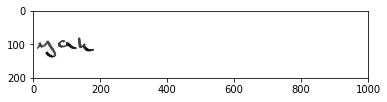

  'yak' -> 'yakz'


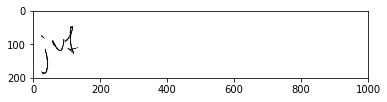

  'jvf' -> 'xvfv'


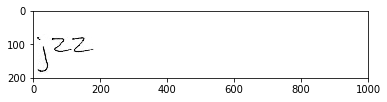

  'jzz' -> 'jzzf'
  Batch: 60 Loss: 0.5150727435822289
100


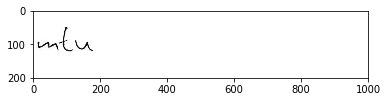

  'mtu' -> 'mtwg'


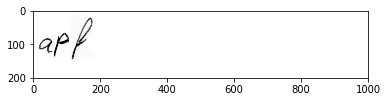

  'apf' -> 'apfw'


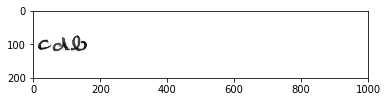

  'cdb' -> 'cdbi'
  Batch: 80 Loss: 0.7682249188795687
100


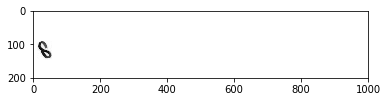

  'g' -> 'gy'


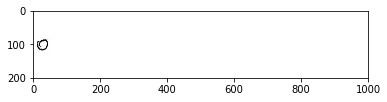

  'o' -> 'od'


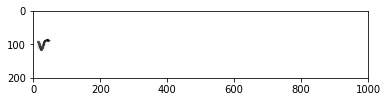

  'r' -> 'rw'
  Batch: 100 Loss: 0.6973639242971937
Test loss: 0.691742
Training epoch 17...
Discr loss: 1.388478
  Batch: 30 Loss: 0.8089763992114201
Discr loss: 1.387831
  Batch: 60 Loss: 0.8760133195420106
Discr loss: 1.388068
  Batch: 90 Loss: 0.7532862691664034
Discr loss: 1.387892
  Batch: 120 Loss: 0.6702357053756715
Discr loss: 1.387688
  Batch: 150 Loss: 0.7224126999162965
Discr loss: 1.387807
  Batch: 180 Loss: 0.8158207212554084
Discr loss: 1.388095
  Batch: 210 Loss: 0.662404195426239
Discr loss: 1.388040
  Batch: 240 Loss: 0.6142728781451781
Discr loss: 1.388210
  Batch: 270 Loss: 0.5036631206174691
Discr loss: 1.387977
  Batch: 300 Loss: 0.6003642670644654
Discr loss: 1.387997
  Batch: 330 Loss: 0.7776590767999492
Discr loss: 1.387671
  Batch: 360 Loss: 0.6965301316190098
Discr loss: 1.388046
  Batch: 390 Loss: 0.806334633703033
Train loss: 0.705939
Discr applied 0 times.
Testing...
100


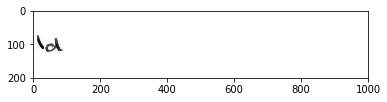

  'ld' -> 'lur'


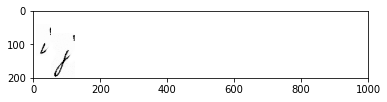

  'ij' -> 'ijp'


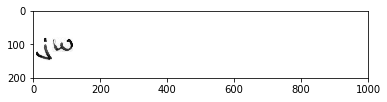

  'jw' -> 'jwp'
  Batch: 20 Loss: 0.6409734735513727
100


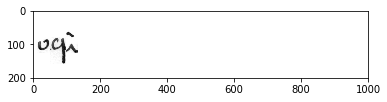

  'vqi' -> 'vyia'


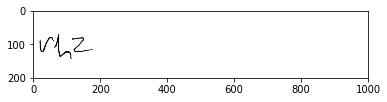

  'rhz' -> 'rhzh'


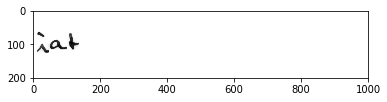

  'iat' -> 'iaty'
  Batch: 40 Loss: 0.5628129109678169
100


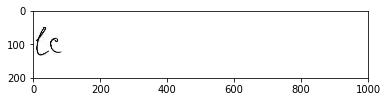

  'lc' -> 'lcf'


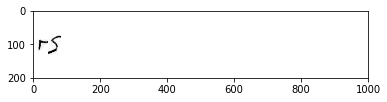

  'rs' -> 'rsi'


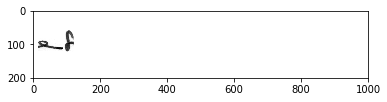

  'ef' -> 'ejj'
  Batch: 60 Loss: 0.5016234060501059
100


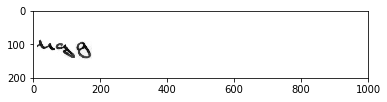

  'hgg' -> 'hgbt'


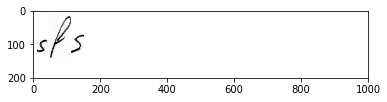

  'sfs' -> 'sfsl'


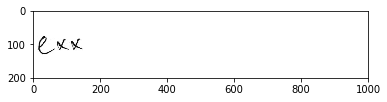

  'exx' -> 'exxl'
  Batch: 80 Loss: 0.5679162090147536
100


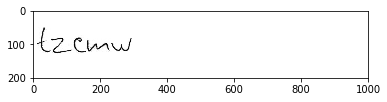

  'tzcmw' -> 'tzamw<START>'


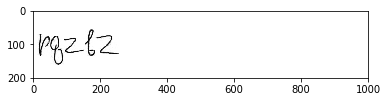

  'pqzbz' -> 'pqzlz<START>'


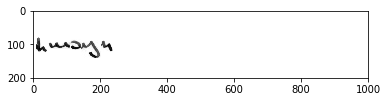

  'hmsyn' -> 'hmvyv<START>'
  Batch: 100 Loss: 0.7230045781408747
Test loss: 0.593333
Training epoch 18...
Discr loss: 1.387855
  Batch: 30 Loss: 0.8458683133373659
Discr loss: 1.387976
  Batch: 60 Loss: 0.6464329613786606
Discr loss: 1.387929
  Batch: 90 Loss: 0.6623718239946499
Discr loss: 1.387923
  Batch: 120 Loss: 0.6585125425044034
Discr loss: 1.387958
  Batch: 150 Loss: 0.6552339680120348
Discr loss: 1.388140
  Batch: 180 Loss: 0.6694613222612277
Discr loss: 1.388005
  Batch: 210 Loss: 0.4774745043367148
Discr loss: 1.388144
  Batch: 240 Loss: 0.7504262203557623
Discr loss: 1.387836
  Batch: 270 Loss: 0.5488341035693883
Discr loss: 1.387887
  Batch: 300 Loss: 0.6455220286879275
Discr loss: 1.388001
  Batch: 330 Loss: 0.6332443863277634
Discr loss: 1.388072
  Batch: 360 Loss: 0.5469654079195526
Discr loss: 1.388155
  Batch: 390 Loss: 0.5519657766363687
Train loss: 0.636586
Discr applied 0 times.
Testing...
100


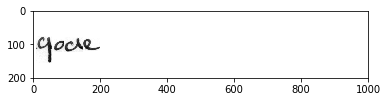

  'qode' -> 'qoucf'


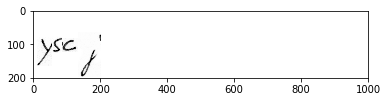

  'yscj' -> 'yccj<STOP>'


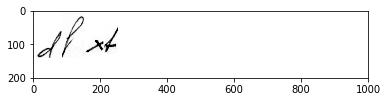

  'dfxt' -> 'dfnnm'
  Batch: 20 Loss: 0.747676329370588
100


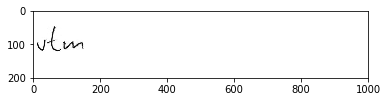

  'vtm' -> 'vlmz'


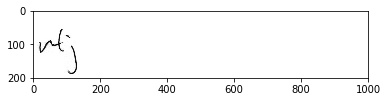

  'rtj' -> 'rljm'


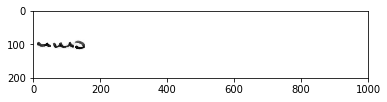

  'nms' -> 'nnsj'
  Batch: 40 Loss: 0.6551149240011972
100


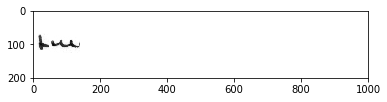

  'tm' -> 'tmp'


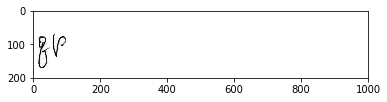

  'qp' -> 'qpy'


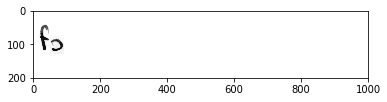

  'fs' -> 'fsv'
  Batch: 60 Loss: 0.528279014279445
100


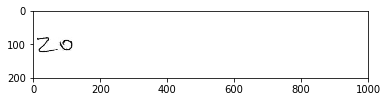

  'zo' -> 'zox'


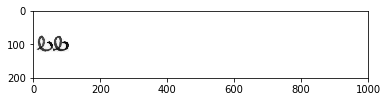

  'bb' -> 'bbs'


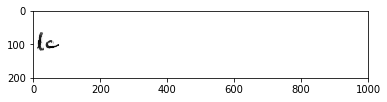

  'lc' -> 'lcz'
  Batch: 80 Loss: 0.6995574311787884
100


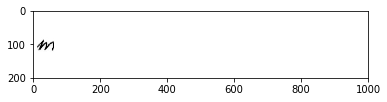

  'm' -> 'mw'


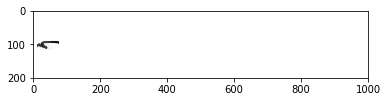

  'r' -> 'rj'


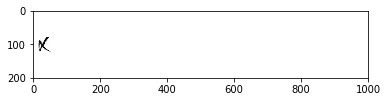

  'x' -> 'xn'
  Batch: 100 Loss: 0.4885514391151567
Test loss: 0.617659
Training epoch 19...
Discr loss: 1.387927
  Batch: 30 Loss: 0.7118653974806268
Discr loss: 1.387978
  Batch: 60 Loss: 0.6406250323106845
Discr loss: 1.387853
  Batch: 90 Loss: 0.7331464675772522
Discr loss: 1.387800
  Batch: 120 Loss: 0.6013624949380756
Discr loss: 1.388266
  Batch: 150 Loss: 0.6225392830909954
Discr loss: 1.387700
  Batch: 180 Loss: 0.7131773660373357
Discr loss: 1.388180
  Batch: 210 Loss: 0.66975360546675
Discr loss: 1.388159
  Batch: 240 Loss: 0.6763198960448304
Discr loss: 1.387919
  Batch: 270 Loss: 0.5663702840813332
Discr loss: 1.387975
  Batch: 300 Loss: 0.749358732543058
Discr loss: 1.388129
  Batch: 330 Loss: 0.6778834196097321
Discr loss: 1.387964
  Batch: 360 Loss: 0.6258526270422671
Discr loss: 1.387785
  Batch: 390 Loss: 0.7102176381564802
Train loss: 0.670886
Discr applied 0 times.
Testing...
100


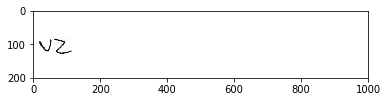

  'vz' -> 'vzx'


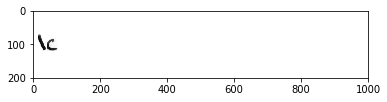

  'lc' -> 'lcx'


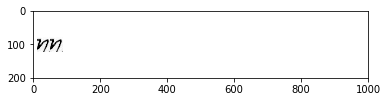

  'nn' -> 'nnm'
  Batch: 20 Loss: 0.6250774288612108
100


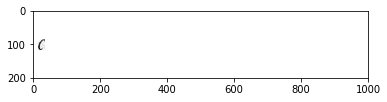

  'c' -> 'co'


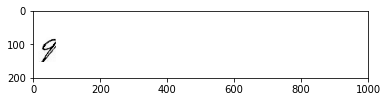

  'q' -> 'qi'


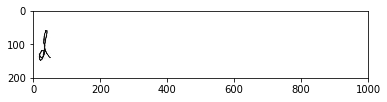

  'd' -> 'dc'
  Batch: 40 Loss: 0.41773001646002134
100


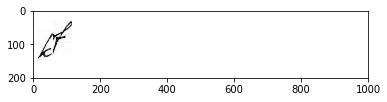

  'kf' -> 'kfg'


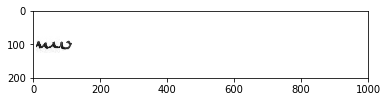

  'mv' -> 'mvs'


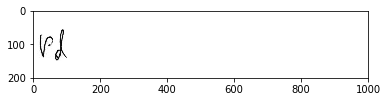

  'pd' -> 'pdh'
  Batch: 60 Loss: 0.5837346344627439
100


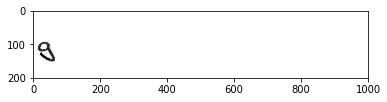

  'g' -> 'ga'


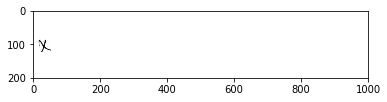

  'x' -> 'xp'


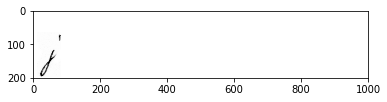

  'j' -> 'jl'
  Batch: 80 Loss: 0.49044403109699486
100


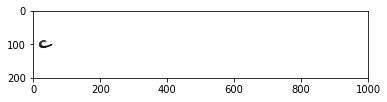

  'c' -> 'cz'


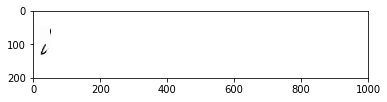

  'i' -> 'ii'


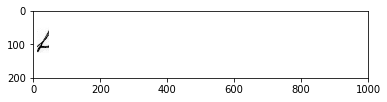

  't' -> 'ta'
  Batch: 100 Loss: 0.6154361968239149
Test loss: 0.541074
Training epoch 20...
Discr loss: 1.387833
  Batch: 30 Loss: 0.6490260611101984
Discr loss: 1.387769
  Batch: 60 Loss: 0.4480824544984433
Discr loss: 1.388144
  Batch: 90 Loss: 0.7016057241418296
Discr loss: 1.387972
  Batch: 120 Loss: 0.6533900886111789
Discr loss: 1.387921
  Batch: 150 Loss: 0.5332059593126178
Discr loss: 1.387806
  Batch: 180 Loss: 0.5632592744421628
Discr loss: 1.387898
  Batch: 210 Loss: 0.5267738522092501
Discr loss: 1.387995
  Batch: 240 Loss: 0.4904468591966563
Discr loss: 1.387875
  Batch: 270 Loss: 0.556123362576796
Discr loss: 1.387968
  Batch: 300 Loss: 0.5129401531608568
Discr loss: 1.388137
  Batch: 330 Loss: 0.7102214064407679
Discr loss: 1.387940
  Batch: 360 Loss: 0.5364415357841386
Discr loss: 1.388092
  Batch: 390 Loss: 0.5957296221247977
Train loss: 0.570708
Discr applied 0 times.
Testing...
100


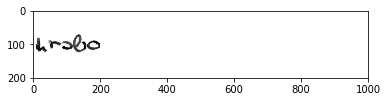

  'hrsbo' -> 'hrgbo<START>'


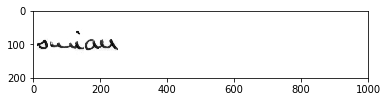

  'smiau' -> 'smidh<START>'


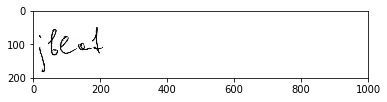

  'jbeaf' -> 'jecdf<START>'
  Batch: 20 Loss: 0.5465971209170918
100


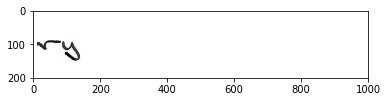

  'ry' -> 'ryw'


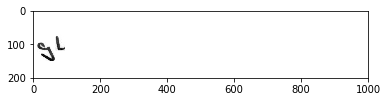

  'gl' -> 'gla'


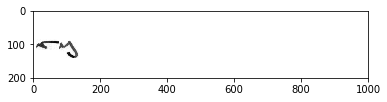

  'ry' -> 'rve'
  Batch: 40 Loss: 0.5682180816556017
100


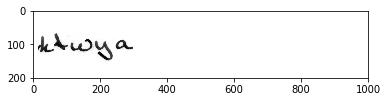

  'ktwya' -> 'ktwwd<START>'


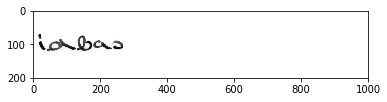

  'idbas' -> 'idoae<START>'


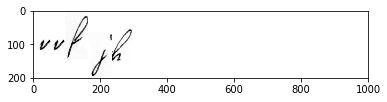

  'vvfjh' -> 'vxfjy<START>'
  Batch: 60 Loss: 0.41418757360428565
100


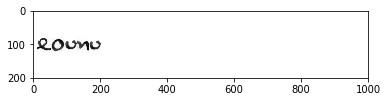

  'eovnv' -> 'eovns<START>'


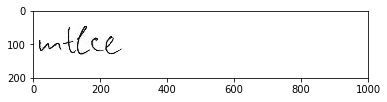

  'mtlce' -> 'mtkek<START>'


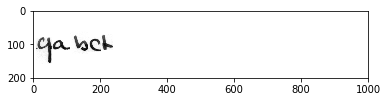

  'qabct' -> 'qatct<START>'
  Batch: 80 Loss: 0.6050480056305726
100


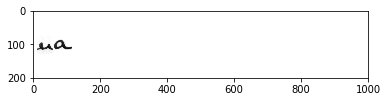

  'na' -> 'naw'


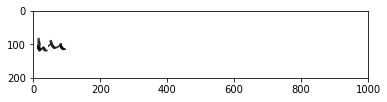

  'hh' -> 'hht'


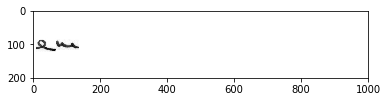

  'em' -> 'emt'
  Batch: 100 Loss: 0.38741166520863773
Test loss: 0.499299
Training epoch 21...
Discr loss: 1.388000
  Batch: 30 Loss: 0.5539357410371305
Discr loss: 1.388205
  Batch: 60 Loss: 0.6932600487851435
Discr loss: 1.388020
  Batch: 90 Loss: 0.6934703030147488
Discr loss: 1.388208
  Batch: 120 Loss: 0.5133495735873779
Discr loss: 1.387925
  Batch: 150 Loss: 0.49231262653238245
Discr loss: 1.387868
  Batch: 180 Loss: 0.640988359451294
Discr loss: 1.387756
  Batch: 210 Loss: 0.488992916751239
Discr loss: 1.387841
  Batch: 240 Loss: 0.5801378840621976
Discr loss: 1.387675
  Batch: 270 Loss: 0.5674290359020233
Discr loss: 1.387826
  Batch: 300 Loss: 0.5038413642636603
Discr loss: 1.387832
  Batch: 330 Loss: 0.5996758854140839
Discr loss: 1.388464
  Batch: 360 Loss: 0.6438954160114129
Discr loss: 1.388060
  Batch: 390 Loss: 0.6715536645096208
Train loss: 0.590526
Discr applied 0 times.
Testing...
100


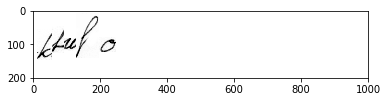

  'ktufo' -> 'kkwqm<START>'


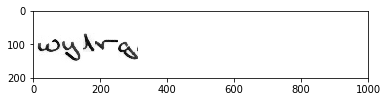

  'wylrg' -> 'wgjdw<START>'


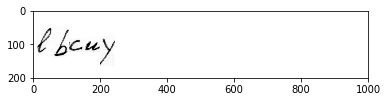

  'lbcuy' -> 'lbzw<STOP><START>'
  Batch: 20 Loss: 0.6536672548390924
100


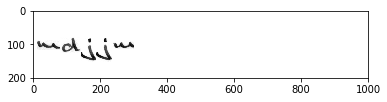

  'mdjjm' -> 'mdjwm<START>'


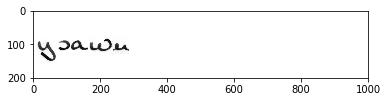

  'ysawn' -> 'ysuwn<START>'


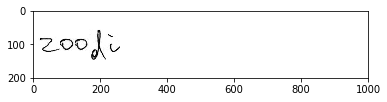

  'zoodi' -> 'zcoh<STOP><START>'
  Batch: 40 Loss: 0.9375289719303449
100


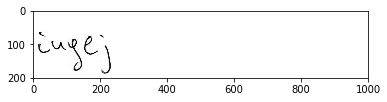

  'iugej' -> 'iugij<START>'


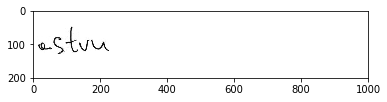

  'astvu' -> 'asiwu<START>'


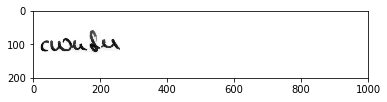

  'cwkfu' -> 'cwhy<STOP><START>'
  Batch: 60 Loss: 0.4995034291595221
100


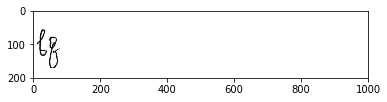

  'bq' -> 'bqj'


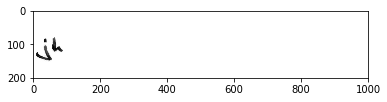

  'jh' -> 'jhh'


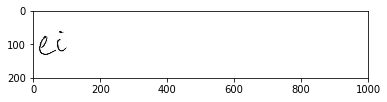

  'ei' -> 'eii'
  Batch: 80 Loss: 0.458665288767467
100


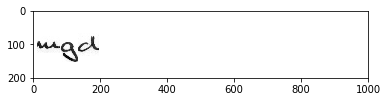

  'mgd' -> 'mgdy'


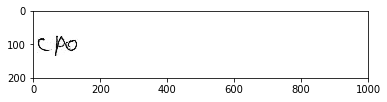

  'cpo' -> 'cpof'


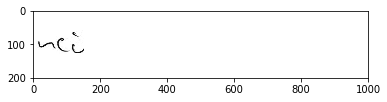

  'nci' -> 'nciw'
  Batch: 100 Loss: 0.5695697976648807
Test loss: 0.617611
Training epoch 22...
Discr loss: 1.387775
  Batch: 30 Loss: 0.5049770455103781
Discr loss: 1.387831
  Batch: 60 Loss: 0.6805407239910629
Discr loss: 1.387826
  Batch: 90 Loss: 0.5953953616445263
Discr loss: 1.387934
  Batch: 120 Loss: 0.5885081741917465
Discr loss: 1.387702
  Batch: 150 Loss: 0.613269876047141
Discr loss: 1.387853
  Batch: 180 Loss: 0.5516460219025612
Discr loss: 1.387861
  Batch: 210 Loss: 0.5989768931517999
Discr loss: 1.387925
  Batch: 240 Loss: 0.509693971781267
Discr loss: 1.387842
  Batch: 270 Loss: 0.5267213845708304
Discr loss: 1.387865
  Batch: 300 Loss: 0.6178939723802939
Discr loss: 1.387814
  Batch: 330 Loss: 0.45854016366518213
Discr loss: 1.388095
  Batch: 360 Loss: 0.5044978741101093
Discr loss: 1.387751
  Batch: 390 Loss: 0.606301308096283
Train loss: 0.563053
Discr applied 0 times.
Testing...
100


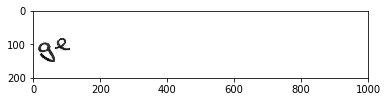

  'ge' -> 'gcm'


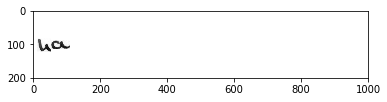

  'ha' -> 'hap'


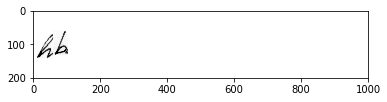

  'hb' -> 'hbc'
  Batch: 20 Loss: 0.47587813531979917
100


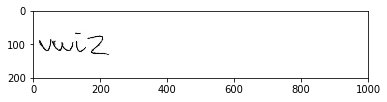

  'vwiz' -> 'vwzzc'


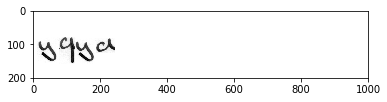

  'yqyd' -> 'ygydz'


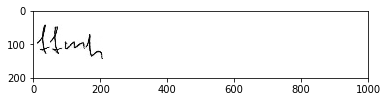

  'ffmh' -> 'ffmw<STOP>'
  Batch: 40 Loss: 0.6280550299026072
100


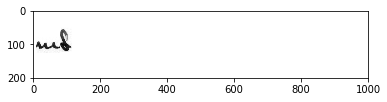

  'mf' -> 'mft'


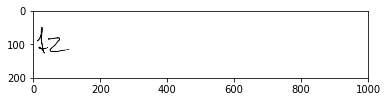

  'fz' -> 'fzj'


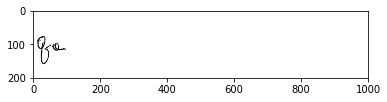

  'qa' -> 'qai'
  Batch: 60 Loss: 0.5775641863731046
100


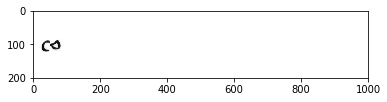

  'cs' -> 'csy'


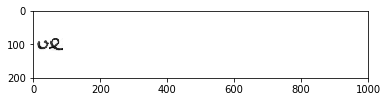

  've' -> 'veg'


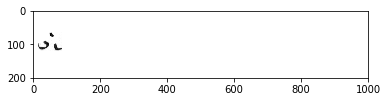

  'vi' -> 'via'
  Batch: 80 Loss: 0.41988409958779815
100


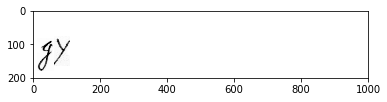

  'gy' -> 'gyb'


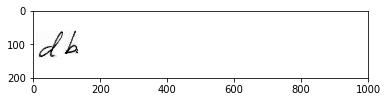

  'db' -> 'dbz'


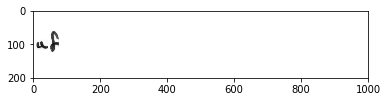

  'uf' -> 'ufi'
  Batch: 100 Loss: 0.5334936586705348
Test loss: 0.521757
Training epoch 23...
Discr loss: 1.387814
  Batch: 30 Loss: 0.5628049987637335
Discr loss: 1.387940
  Batch: 60 Loss: 0.5759734587702486
Discr loss: 1.388057
  Batch: 90 Loss: 0.6407756527720226
Discr loss: 1.387811
  Batch: 120 Loss: 0.501465691352884
Discr loss: 1.387814
  Batch: 150 Loss: 0.5588705365235606
Discr loss: 1.387829
  Batch: 180 Loss: 0.5973435014838145
Discr loss: 1.387864
  Batch: 210 Loss: 0.5097870496619079
Discr loss: 1.387995
  Batch: 240 Loss: 0.45071428578760886
Discr loss: 1.387947
  Batch: 270 Loss: 0.5866120327015718
Discr loss: 1.388150
  Batch: 300 Loss: 0.4878846036684183
Discr loss: 1.387908
  Batch: 330 Loss: 0.48576340729991596
Discr loss: 1.387780
  Batch: 360 Loss: 0.4794910469361478
Discr loss: 1.387870
  Batch: 390 Loss: 0.4930496218800544
Train loss: 0.530195
Discr applied 0 times.
Testing...
100


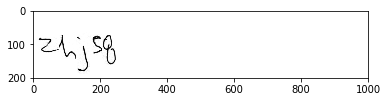

  'zhjsq' -> 'zhssq<START>'


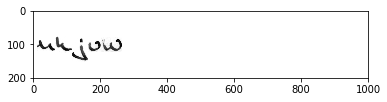

  'hkjvw' -> 'hkjww<START>'


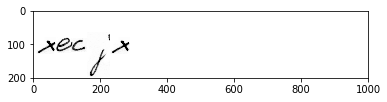

  'xecjx' -> 'xecjv<START>'
  Batch: 20 Loss: 0.49119635168462994
100


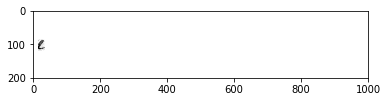

  'e' -> 'eu'


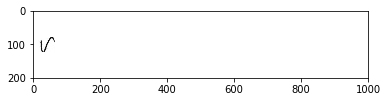

  'r' -> 'rz'


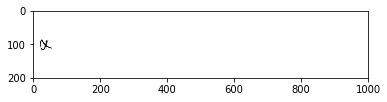

  'x' -> 'xz'
  Batch: 40 Loss: 0.5853843988447138
100


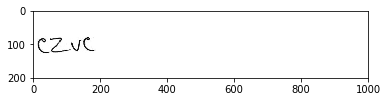

  'czvc' -> 'czvcc'


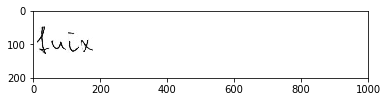

  'fuix' -> 'fuiry'


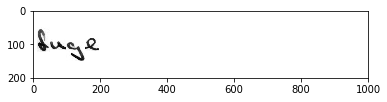

  'fuge' -> 'fwget'
  Batch: 60 Loss: 0.5266226710937917
100


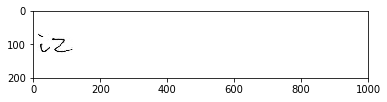

  'iz' -> 'iza'


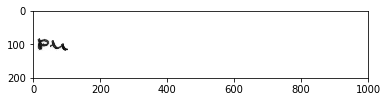

  'ph' -> 'pwy'


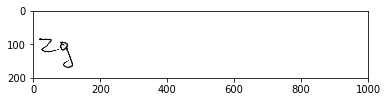

  'zg' -> 'zgy'
  Batch: 80 Loss: 0.49237297108396894
100


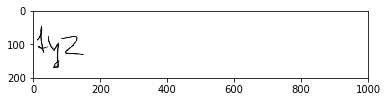

  'fyz' -> 'fbzf'


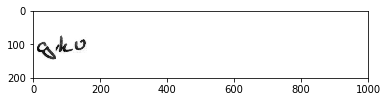

  'gkv' -> 'gkvq'


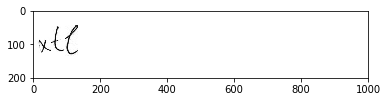

  'xtl' -> 'xtlt'
  Batch: 100 Loss: 0.5011055676204463
Test loss: 0.514194
Training epoch 24...
Discr loss: 1.388013
  Batch: 30 Loss: 0.46376701036261186
Discr loss: 1.387760
  Batch: 60 Loss: 0.4561995494365692
Discr loss: 1.388337
  Batch: 90 Loss: 0.5513265624062883
Discr loss: 1.387785
  Batch: 120 Loss: 0.46418042617953487
Discr loss: 1.387779
  Batch: 150 Loss: 0.511831150845521
Discr loss: 1.387780
  Batch: 180 Loss: 0.5911436268480288
Discr loss: 1.387809
  Batch: 210 Loss: 0.5838633788501223
Discr loss: 1.387962
  Batch: 240 Loss: 0.5104466164070699
Discr loss: 1.388066
  Batch: 270 Loss: 0.65594316277653
Discr loss: 1.387868
  Batch: 300 Loss: 0.4466650157711572
Discr loss: 1.387921
  Batch: 330 Loss: 0.5062401253647274
Discr loss: 1.387822
  Batch: 360 Loss: 0.6132501475885511
Discr loss: 1.387906
  Batch: 390 Loss: 0.5161923373200827
Train loss: 0.521264
Discr applied 0 times.
Testing...
100


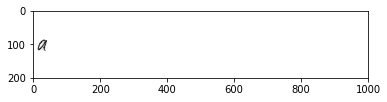

  'a' -> 'ac'


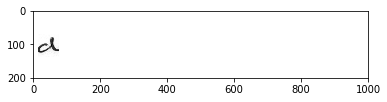

  'd' -> 'dc'


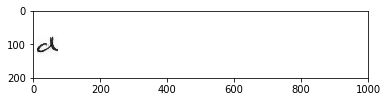

  'd' -> 'dn'
  Batch: 20 Loss: 0.5700744451085727
100


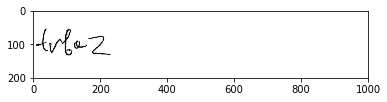

  'trbaz' -> 'tpbzi<START>'


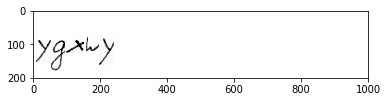

  'ygxwy' -> 'yoxyj<START>'


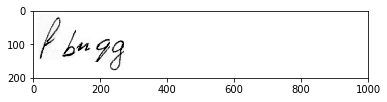

  'fbnqg' -> 'fbaqx<START>'
  Batch: 40 Loss: 0.553856542762369
100


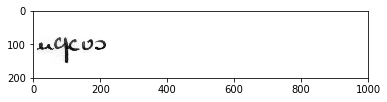

  'nqcvs' -> 'nqcv<STOP><START>'


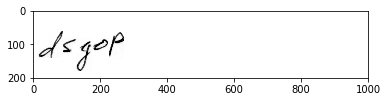

  'dsgop' -> 'dqqee<START>'


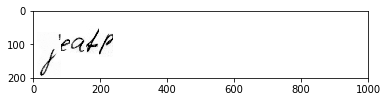

  'jeatp' -> 'jealt<START>'
  Batch: 60 Loss: 0.4820815724103401
100


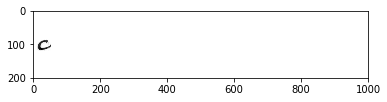

  'c' -> 'cg'


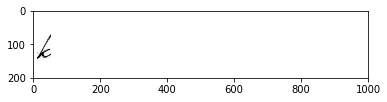

  'k' -> 'kz'


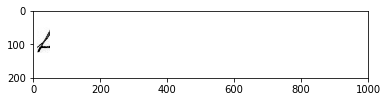

  't' -> 'tv'
  Batch: 80 Loss: 0.34672493688141304
100


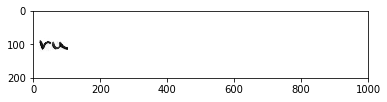

  'ru' -> 'rue'


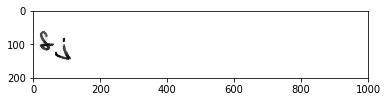

  'fj' -> 'fjk'


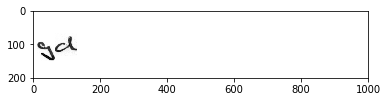

  'gd' -> 'gdp'
  Batch: 100 Loss: 0.400441577769816
Test loss: 0.465976
Training epoch 25...
Discr loss: 1.387866
  Batch: 30 Loss: 0.4627690131527682
Discr loss: 1.387851
  Batch: 60 Loss: 0.5835125745791526
Discr loss: 1.387933
  Batch: 90 Loss: 0.5988558087125422
Discr loss: 1.387863
  Batch: 120 Loss: 0.5142077018403345
Discr loss: 1.387796
  Batch: 150 Loss: 0.5197739083319901
Discr loss: 1.387901
  Batch: 180 Loss: 0.46168357996063103
Discr loss: 1.388010
  Batch: 210 Loss: 0.5013436275141107
Discr loss: 1.387880
  Batch: 240 Loss: 0.585712862672905
Discr loss: 1.387928
  Batch: 270 Loss: 0.4499701089867287
Discr loss: 1.388158
  Batch: 300 Loss: 0.43530768894900873
Discr loss: 1.388112
  Batch: 330 Loss: 0.49820383503619164
Discr loss: 1.387925
  Batch: 360 Loss: 0.5444600545201036
Discr loss: 1.388005
  Batch: 390 Loss: 0.4815162754058838
Train loss: 0.513709
Discr applied 0 times.
Testing...
100


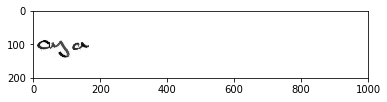

  'oya' -> 'oyav'


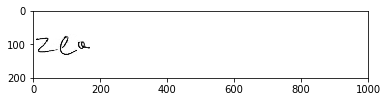

  'zea' -> 'zeav'


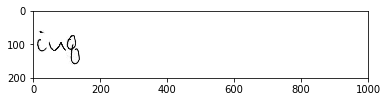

  'iuq' -> 'iugn'
  Batch: 20 Loss: 0.4215103184742232
100


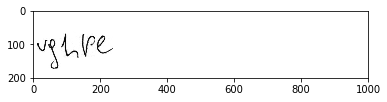

  'vghpe' -> 'vghpe<START>'


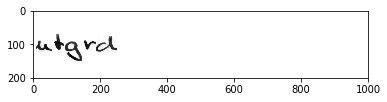

  'ktgrd' -> 'ktgdk<START>'


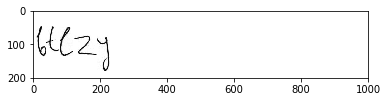

  'btlzy' -> 'blkzy<START>'
  Batch: 40 Loss: 0.4965929550553361
100


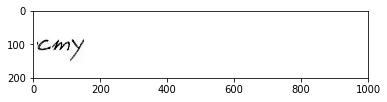

  'cmy' -> 'cmyw'


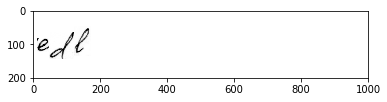

  'edl' -> 'edhy'


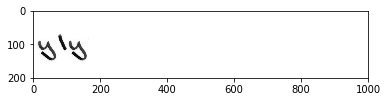

  'yly' -> 'ylyg'
  Batch: 60 Loss: 0.4453936665877699
100


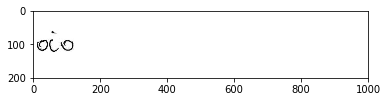

  'oio' -> 'ocos'


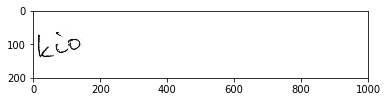

  'kio' -> 'kioy'


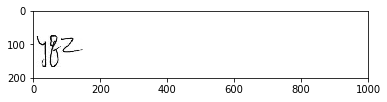

  'yqz' -> 'yfzj'
  Batch: 80 Loss: 0.4377062112092972
100


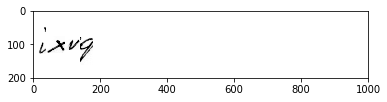

  'ixvq' -> 'ixvgk'


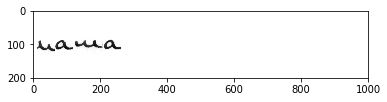

  'hama' -> 'hamcv'


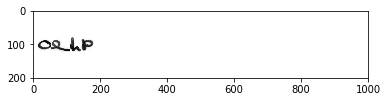

  'oehp' -> 'oehff'
  Batch: 100 Loss: 0.43048397997394205
Test loss: 0.441918
Training epoch 26...
Discr loss: 1.387869
  Batch: 30 Loss: 0.5082840243023303
Discr loss: 1.387717
  Batch: 60 Loss: 0.5317741862311959
Discr loss: 1.388048
  Batch: 90 Loss: 0.5134591165309151
Discr loss: 1.387809
  Batch: 120 Loss: 0.6153870817439422
Discr loss: 1.387762
  Batch: 150 Loss: 0.5243221744274099


In [0]:
for i in range(0, 100):
  max_size = 6
  train(i, max_size, True)
  test(max_size)

In [0]:
test(1)

In [0]:
# state_dict = {
#         "encoder": encoder.state_dict(),
#         "encoder_optimizer": encoder_optimizer.state_dict(),
#         "decoder": decoder.state_dict(),
#         "decoder_optimizer": decoder_optimizer.state_dict(),
#         "discriminator": discriminator.state_dict(),
#         "discriminator_optimizer": discriminator_optimizer.state_dict(),
#       }

# torch.save(state_dict, file_name)


In [0]:
test(2)

In [0]:
data, target = artificial_data.make_random_batch(3, 200)

In [0]:
for i in range(0, 30):
  plt.imshow(data[i])
  plt.show()
  print(test_set.decode_word(target[i]))